In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.objects.sim_utils as su

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

import analyze2p.correlations as cr

In [4]:
%matplotlib notebook

# Plotting

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

# Source

In [6]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)
#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


# Output dir

In [12]:
corr_dir = os.path.join(aggregate_dir, 'correlations', 
                    'gratings_%s_%s' % (response_type, responsive_test))
print(corr_dir)
#### Set current output dir
dst_dir = os.path.join(corr_dir, 'pref_theta')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta


# Load trial metrics

In [13]:
# Load metadata
trial_epoch='stimulus'
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
# Load trial metrics
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
Stimulus: gratings (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |           883 |
| Lm |           466 |
| Li |           431 |


# Load all fits

In [17]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)
# One stim config per cell
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

In [18]:
print("Filter by combined R2:")
print(gdata[gdata['r2comb']>0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())
print("Filter by Goodness-of-Fit thr:")
print(gdata[gdata['gof']>0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

Filter by combined R2:
|    |   visual_area |
|:---|--------------:|
| V1 |           670 |
| Lm |           309 |
| Li |           195 |
Filter by Goodness-of-Fit thr:
|    |   visual_area |
|:---|--------------:|
| V1 |           444 |
| Lm |           222 |
| Li |            90 |


In [33]:
# Unique datasets, get dsets with most ncells pass
min_ncells=5
gof_thr=0.5
drop_repeats=True
counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
# Get unique dkeys based on # cells fit
u_dkeys = aggr.drop_repeats(counts[counts['n_cells']>=min_ncells].copy(), 
                            colname='n_cells')   
FITS = pd.concat([g for (va, dk), g \
                in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])
ncells_fit = aggr.count_n_cells(FITS)
ncells_fit.groupby('visual_area').sum()

# Drop repeat FOVs for trial metrics
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

FINAL totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       193 |         4 |
| Lm            |       455 |         7 |
| V1            |       883 |         8 |


# Get RF fits

In [22]:
# Load RF data
response_type='dff'
do_spherical_correction=True
# ---------------------------------------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(CELLS, sdata, response_type=response_type,
                       do_spherical_correction=do_spherical_correction,
                        reliable_only=False, pass_criterion='position', 
                        combine='average')
print(rfdf['experiment'].unique())
rfdf['rf_theta_deg'] = [np.rad2deg(i) % 180 for i in rfdf['theta_Mm_c'].values]
rfdf = aggr.add_roi_positions(rfdf.copy())
# print stuff
rf_counts = aggr.count_n_cells(rfdf)
rf_counts.groupby('visual_area').sum()
# Load RF polys
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
['average_rfs']


In [34]:
FITS_counts = aggr.count_n_cells(FITS)
FITS_counts.groupby('visual_area').sum()

n_cells
visual_area         
Li                50
Lm               214
V1               444

In [36]:
fits_rfs = pd.merge(FITS, rfdf, on=['visual_area', 'datakey', 'cell'], how='left')
fits_rfs.shape, FITS.shape

((708, 60), (708, 23))

## Check fit params

<IPython.core.display.Javascript object>


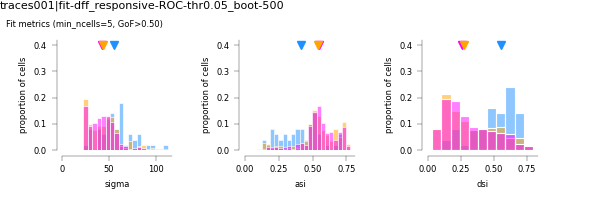

No handles with labels found to put in legend.


sigma                                                         \
             count       mean        std        min        25%        50%   
visual_area                                                                 
Li            50.0  57.477293  18.130869  24.726046  47.077840  55.520880   
Lm           214.0  44.403026  17.296628  22.500891  29.947048  43.431166   
V1           444.0  42.853306  14.983083  22.500000  31.655521  42.364704   

                                      asi            ...                      \
                   75%         max  count      mean  ...       75%       max   
visual_area                                          ...                       
Li           64.555164  112.835255   50.0  0.404227  ...  0.509026  0.712300   
Lm           54.422269  103.381291  214.0  0.537804  ...  0.656035  0.778732   
V1           51.301001  110.928101  444.0  0.550414  ...  0.629558  0.767962   

               dsi                                                    \
             count      mean       std       min       25%       50%   
visual_area                                                            
Li            50.0  0.503419  0.162899  0.143466  0.423744  0.553148   
Lm           214.0  0.317448  0.191069  0.033093  0.149226  0.269207   
V1           444.0  0.307009  0.178261  0.032861  0.159579  0.256058   

                                 
                  75%       max  
visual_area                      
Li           0.622401  0.733748  
Lm           0.470399  0.790448  
V1           0.444182  0.792704  

[3 rows x 24 columns]

In [48]:
%matplotlib notebook
means_= FITS.groupby('visual_area').median()

plot_params = [ 'sigma', 'asi', 'dsi' ]
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))

ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=FITS, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_box_aspect(1)
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.9, wspace=0.6)
sns.despine(offset=4)
fig.text(0.01, 0.87, 'Fit metrics (min_ncells=%i, GoF>%.2f)' % (min_ncells, gof_thr))

pplot.label_figure(fig, data_id)
figname = 'fitparams_hist'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

FITS.groupby(['visual_area'])[plot_params].describe()

<IPython.core.display.Javascript object>


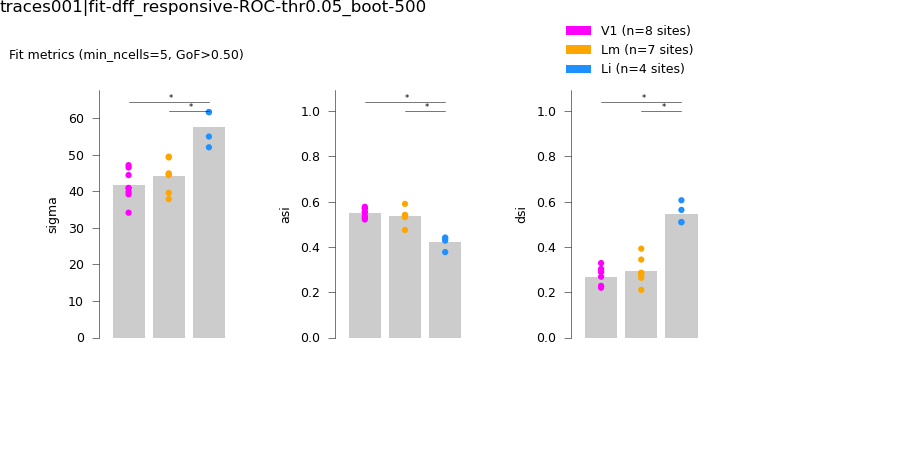

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta fitparams_byFOV
sigma ----------------------------
             count   mean   std    min    25%    50%    75%    max
visual_area                                                       
Li             4.0  57.58  4.85  52.04  54.24  58.30  61.64  61.69
Lm             7.0  44.31  4.40  37.86  42.00  44.64  47.08  49.48
V1             8.0  41.63  4.28  34.14  39.69  40.89  44.95  47.15
asi ----------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             4.0  0.42  0.03  0.38  0.41  0.43  0.44  0.44
Lm             7.0  0.54  0.03  0.47  0.53  0.54  0.54  0.59
V1             8.0  0.55  0.02  0.52  0.53  0.55  0.57  0.58
dsi ----------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             4.0  0.55  0.05  0.

In [47]:
# Plot PER FOV averages
%matplotlib notebook
plot_params = ['sigma', 'asi', 'dsi']
fov_meds = FITS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,3),dpi=150)
y_loc=0.7
for ax, par in zip(axn.flat, plot_params):
    y_loc=np.ceil(fov_meds[par].max())
    offset = y_loc/25
    pplot.stripplot_metric_by_area(fov_meds, ax=ax, metric=par,markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
    ax.set_xticklabels('')
va_labels = dict((va, '%s (n=%i sites)' % (va, len(g['datakey'].unique()))) \
             for va, g in fov_meds.groupby('visual_area'))
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=[va_labels[v] for v in visual_areas],
                                   linestyles='', use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1.01,1.01), loc='lower right', 
          frameon=False, markerscale=0.25)
pplot.adjust_subplots(bottom=0.25, right=0.8)
sns.despine(offset=4, bottom=True)
fig.text(0.01, 0.87, 'Fit metrics (min_ncells=%i, GoF>%.2f)' % (min_ncells, gof_thr))

pplot.label_figure(fig, data_id)
figname = 'fitparams_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
for par in plot_params:
    print("%s ----------------------------" % par)
    print(fov_meds.groupby(['visual_area'])[par].describe().round(2))
    

# Aggregate

In [25]:
# FITS['experiment'] = 'gratings'
# posdf_ = cr.get_roi_pos_and_rfs(FITS[FITS['gof']>gof_thr], curr_rfs=rfdf, 
#                                  rfs_only=False, position_only=False,
#                                  merge_cols=['visual_area', 'datakey', 'cell'])

#### Tuning similarity

In [49]:
FITS['experiment'] = 'gratings'
curr_fits = FITS[(FITS.gof>0.5)].copy() # & (FITS.dsi>=0.3)].copy()
count_strong = aggr.count_n_cells(curr_fits)
count_strong.groupby('visual_area').sum()

n_cells
visual_area         
Li                50
Lm               214
V1               444

In [50]:
DISTS = cr.aggregate_tuning_curve_ccdist(curr_fits, rfdf=rfdf, rfpolys=rfpolys, 
                                         min_ncells=5)

    (20191111_JC120_fov1 NONE, skipping overlaps)
    (20190306_JC061_fov2 NONE, skipping overlaps)
    (20190627_JC091_fov1 NONE, skipping overlaps)
[]


In [51]:
DISTS.columns

Index(['xcorr', 'pearsons', 'cosim', 'cell_1', 'cell_2', 'neuron_pair',
       'pref_dir_diff', 'pref_dir_diff_abs', 'pref_ori_diff',
       'pref_ori_diff_abs', 'sigma', 'response_pref', 'rf_distance', 'max_ecc',
       'min_ecc', 'cortical_distance', 'area_overlap', 'perc_overlap',
       'rf_angle_diff', 'rf_angle_diff_abs', 'std_x', 'std_y', 'aspect_ratio',
       'overlap_index', 'visual_area', 'datakey', 'n_cells'],
      dtype='object')

# Signal correlations

In [87]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [52]:
SDF = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='gratings',
                      images_only=False,rename=False, 
                      return_incorrect=False, return_all=False)
select_stimuli='all'
distance_var = 'rf_distance'
min_ncells=5
CORRS = cr.aggregate_ccdist(NDATA, experiment='gratings', #rfdf=rfdf, #rfpolys=rfpolys,
                        SDF=SDF, select_stimuli=select_stimuli, min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Checking gratings configs
Dist: cortical_distance
Li 20190602_JC091_fov1 gratings
Li 20190609_JC099_fov1 gratings
Li 20190614_JC091_fov1 gratings
Li 20191111_JC120_fov1 gratings
Lm 20190306_JC061_fov2 gratings
Lm 20190512_JC083_fov1 gratings
Lm 20190513_JC078_fov1 gratings
Lm 20190525_JC084_fov1 gratings
Lm 20190603_JC080_fov1 gratings
Lm 20190618_JC097_fov1 gratings
Lm 20190627_JC091_fov1 gratings
V1 20190511_JC083_fov1 gratings
V1 20190512_JC083_fov1 gratings
V1 20190522_JC084_fov1 gratings
V1 20190613_JC097_fov1 gratings
V1 20190616_JC097_fov1 gratings
V1 20190617_JC097_fov1 gratings
V1 20190622_JC085_fov1 gratings
V1 20191006_JC110_fov1 gratings
5 datasets w wrong configs:
    ('Lm', '20190306_JC061_fov2')
    ('Lm', '20190512_JC083_fov1')
    ('Lm', '20190513_JC078_fov1')
    ('V1', '20190511_JC083_fov1')
    ('V1', '20190512_JC083_fov1')
0 datasets w/out RF fits:


In [53]:
DISTS.shape, CORRS.shape

((19379, 27), (63656, 10))

In [54]:
CORRS.columns

Index(['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
       'cortical_distance', 'visual_area', 'datakey', 'experiment', 'n_cells'],
      dtype='object')

In [55]:
DISTS.columns

Index(['xcorr', 'pearsons', 'cosim', 'cell_1', 'cell_2', 'neuron_pair',
       'pref_dir_diff', 'pref_dir_diff_abs', 'pref_ori_diff',
       'pref_ori_diff_abs', 'sigma', 'response_pref', 'rf_distance', 'max_ecc',
       'min_ecc', 'cortical_distance', 'area_overlap', 'perc_overlap',
       'rf_angle_diff', 'rf_angle_diff_abs', 'std_x', 'std_y', 'aspect_ratio',
       'overlap_index', 'visual_area', 'datakey', 'n_cells'],
      dtype='object')

In [56]:
DISTS = DISTS.rename(columns={'n_cells':'n_cells_fit'})
CORRS = CORRS.rename(columns={'n_cells':'n_cells_responsive'})

In [59]:
ccdist = pd.merge(CORRS, DISTS,
            on=['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2',
               'cortical_distance'], 
            how='outer', suffixes=('_fit', '_responsive'))

In [60]:
ccdist.shape

(68541, 31)

<IPython.core.display.Javascript object>


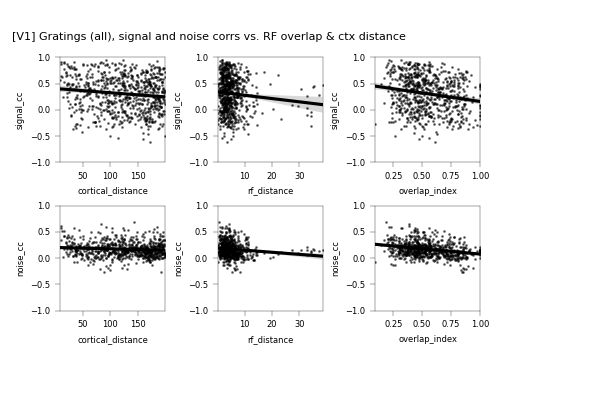

Text(0.02, 0.9, '[V1] Gratings (all), signal and noise corrs vs. RF overlap & ctx distance')

In [62]:
va='V1'
ctx_maxdist=200
scatter_kws={'s':1, 'alpha':0.5, 'color':'k'}

metric='noise_cc'
dist_vars=['cortical_distance','rf_distance', 'overlap_index']

df = ccdist[(ccdist.visual_area==va) 
           & (ccdist.cortical_distance<=ctx_maxdist)].copy().dropna()
fig, axn =pl.subplots(2, 3, figsize=(6,4))
# sns.scatterplot(x='area_overlap', y='pearsons', data=df, ax=ax, 
#                 s=2, color='k', alpha=0.5)
for ri, metric in enumerate(['signal_cc', 'noise_cc']):
    for ci, dist_var in enumerate(dist_vars):
        ax=axn[ri, ci]
        sns.regplot(x=dist_var, y=metric, data=df, ax=ax,
                    scatter_kws=scatter_kws, color='k')
        pl.subplots_adjust(bottom=0.2, right=0.8)
        ax.set_ylim([-1, 1])

# ax=axn[0, 2]
# sns.regplot(x='cortical_distance', y='overlap_index', data=df, ax=ax,
#                 scatter_kws=scatter_kws, color='k')
# ax=axn[1, 2]
# sns.regplot(x='signal_cc', y='noise_cc', data=df, ax=ax,
#                 scatter_kws=scatter_kws, color='k')
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.5)
fig.text(0.02, 0.9, \
    '[%s] Gratings (%s), signal and noise corrs vs. RF overlap & ctx distance' \
         % (va, select_stimuli), fontsize=8)

# Average DIST metrics, for tuning similarity metric

In [173]:
ctx_maxdist = 200
va='V1'
df = ccdist[(ccdist.cortical_distance<=ctx_maxdist)
          & (ccdist.visual_area==va)].copy() #.dropna()

df, dist_lut = cr.get_bins_and_cut(df, 
                                   ori_step=15, dir_step=15, ctx_step=25, rf_step=2)

<IPython.core.display.Javascript object>


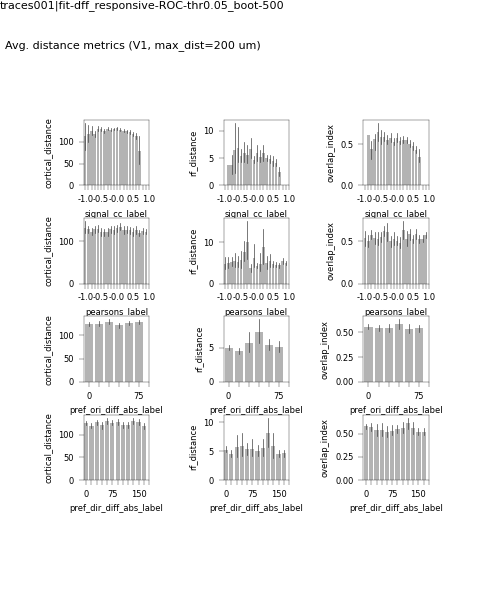

In [174]:
#x_var = 'pref_ori_diff_abs'

metric_vars = ['signal_cc', 'pearsons', 'pref_ori_diff_abs', 'pref_dir_diff_abs']
dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']
fig, axn =pl.subplots(len(metric_vars), len(dist_vars),figsize=(5,6))
for ri, x_var in enumerate(metric_vars):
    x_bins = dist_lut[x_var]['bins']
    xticks=np.arange(0, len(x_bins))
    for ci, y_var in enumerate(dist_vars):
        ax=axn[ri, ci]
        sns.barplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
                    color=[0.7]*3, errwidth=0.5)
#         sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, size=1,
#                   jitter=False, color='k')
        ax.set_xticks(xticks)
        ax.set_xticklabels([round(x_bins[i], 1) if i in xticks[0::5] else ''
                           for i in xticks])
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.3, hspace=0.5, top=0.8)
fig.text(0.01, 0.92, 'Avg. distance metrics (%s, max_dist=%i um)' 
         % (va, ctx_maxdist), fontsize=8)

pplot.label_figure(fig, data_id)


In [158]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


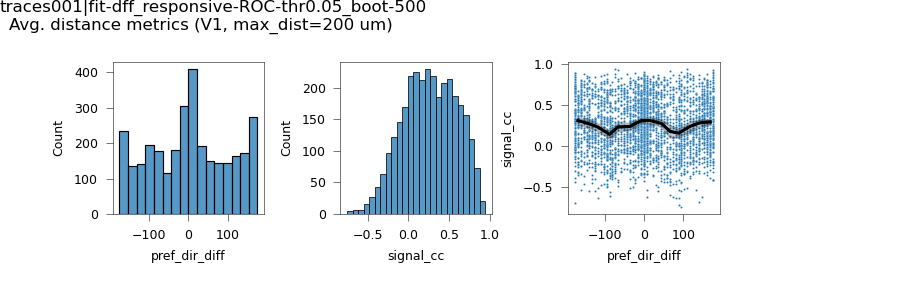

In [117]:
va='V1'

vg = ccdist[ccdist.visual_area==va].copy().dropna()
fig, axn = pl.subplots(1, 3, figsize=(6,2), dpi=150)
ax=axn[0]
sns.histplot(x='pref_dir_diff', data=vg, ax=ax)
ax=axn[1]
sns.histplot(x='signal_cc', data=vg, ax=ax)
ax=axn[2]
sns.scatterplot(x='pref_dir_diff', y='signal_cc', ax=ax, data=vg, s=1)
# curr_bins = np.linspace(-180, 180, 45)
bin_var='pref_dir_diff'
curr_bins = np.linspace(-180, 180, 15)
vg = cr.cut_bins(vg, curr_bins, bin_var, include_lowest=True)
sns.lineplot(x='%s_value' % bin_var, y='signal_cc', ax=ax, data=vg,
                color='k')
for ax in axn:
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.8,  wspace=0.5)

fig.text(0.01, 0.9, 'Avg. distance metrics (%s, max_dist=%i um)' 
         % (va, ctx_maxdist), fontsize=8)

pplot.label_figure(fig, data_id)


## Binned distance vs. metric (w shuffle)

In [166]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'tuned'
# ----------------------------------
if tuned_or_resp=='responsive':
    df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
elif tuned_or_resp =='tuned':
    df = ccdist[(ccdist.cortical_distance<=ctx_maxdist)].copy().dropna()
# CUT BINS
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
hue_label = '%s_label' % dist_var
x_var = '%s_label' % dist_var

In [167]:
curr_maxdist = dist_lut[dist_var]['max_dist']
bcorrs=df.copy().reset_index(drop=True).dropna()
# shuffle
n_iters=100
shuffle_label = '%s_label' % dist_var #'binned_cortical_distance_label'
dist_bins = dist_lut[dist_var]['bins']
curr_dist_bins=[k for k in dist_bins if k<=curr_maxdist]
mean_cols = ['visual_area',  shuffle_label]
bcorrs_shuff = bcorrs.copy()
shuff_list=[]
for i in np.arange(0, n_iters):
    # Make copy
    vg_shuff = bcorrs_shuff.copy()
    # Shuffle by area
    vg_shuff[shuffle_label] = bcorrs_shuff.groupby(['visual_area'])[shuffle_label]\
                                .transform(np.random.permutation)
    # Get mean 
    mean_ = vg_shuff.groupby(mean_cols).mean().reset_index()
    shuff_list.append(mean_)
shuff_ = pd.concat(shuff_list, axis=0, ignore_index=True)

shuff_['condition'] = 'shuffled'
bcorrs['condition'] = 'data'
combined_ = pd.concat([bcorrs, shuff_], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


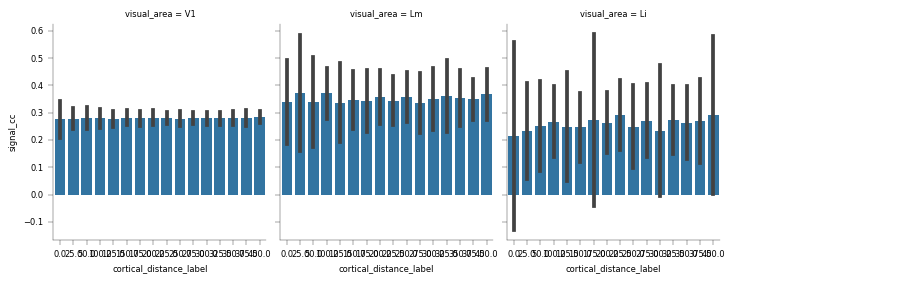

In [168]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=shuff_)
fg.map(sns.barplot, shuffle_label, 'signal_cc' , ci='sd')
pl.subplots_adjust(bottom=0.2, right=0.8)


<IPython.core.display.Javascript object>


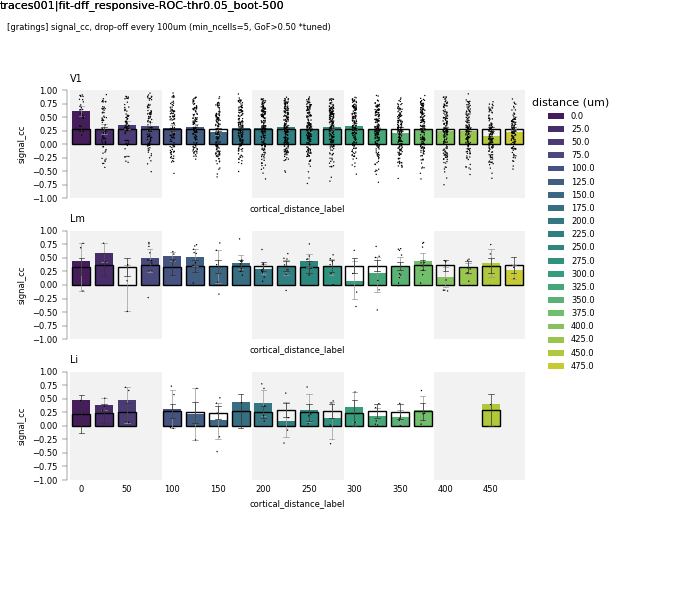

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta binned-dist-bar_signal_cc_v_cortical_distance_tuned_max500_wpairs


In [169]:

%matplotlib notebook
bin_width=5 if dist_var=='rf_distance' else 4
curr_maxdist=60 if dist_var=='rf_distance' else 500
plot_pairs = True
# --------------------------------------------
sorted_x_vars = [k for k, v in df.groupby(x_var) if k<=curr_maxdist]
x_bins = sorted(sorted_x_vars)
xticks = np.arange(0, len(x_bins))
if dist_var=='cortical_distance':
    xlabels = [int(i) if i in x_bins[0::2] else ''\
                        for i in x_bins]
else:
    xlabels = [float(i) if i in x_bins[0::2] else ''\
                        for i in x_bins]
dist_cols = sns.color_palette(cmap, n_colors=len(x_bins))
dist_cdict = dict((k, v) for k, v in zip(x_bins, dist_cols))
#
plotd = combined_[combined_[dist_var]<curr_maxdist].copy()
dist_unit = 'um' if dist_var=='cortical_distance' else 'deg.'
plot_str = '_wpairs' if plot_pairs else ''

ymax=1
fig, axn = pl.subplots(3, 1, figsize=(7,6),sharex=True, sharey=True)
for va, vg0 in plotd.groupby('visual_area'):
    vg = vg0[vg0['condition']=='data']
    ax=axn[visual_areas.index(va)]
    # Set ticks
    if va =='V1' or va=='Lm':
        ax.set_xlabel('')
    else:
        ax.set_xlabel('%s bin (%s)' % (dist_var, dist_unit))
    ax.set_ylim([-ymax, ymax])
    # background patch?
    ymin = ax.get_ylim()[0]
    yh = ax.get_ylim()[-1] - ymin
    rect_list=[]
    for bi, bv in enumerate(sorted_x_vars):
        if bi%int(bin_width*2)==0:
            rect = mpl.patches.Rectangle((bi-0.5, ymin), 
                                         bin_width, yh, fc=[0.95]*3)
        rect_list.append(rect)
    rect_coll=mpl.collections.PatchCollection(rect_list, zorder=-100,
                                             match_original=True)
    ax.add_collection(rect_coll)
    # bars
    sns.barplot(x=x_var, y=y_var, data=vg, ax=ax,
               order=sorted_x_vars, errcolor=[0.6]*3,
               hue=hue_label, dodge=False, ci=95, errwidth=0.5,
               palette=dist_cdict, zorder=1,alpha=1, capsize=0.25)
    if va=='V1':
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
              title='distance (%s)' % dist_unit)
    else:
        ax.legend_.remove()
    # Shuffled mean
    vg_shuff = vg0[vg0.condition=='shuffled']
    sns.barplot(x=x_var, y=y_var, data=vg_shuff, ax=ax, errcolor=[0.2]*3,
                order=sorted_x_vars, dodge=False, ci='sd', errwidth=0.5, lw=1,
                zorder=1, facecolor=(1,1,1,0), edgecolor=['k']*4,capsize=0.25)
    # individual neuron pairs
    if plot_pairs:
        sns.stripplot(x=x_var, y=y_var, ax=ax, data=vg, color='k', #palette=grp_colors,
               order=sorted_x_vars, dodge=False, size=1)
    
    ax.set_title(va, loc='left', fontsize=7)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels(xlabels)
sns.despine(bottom=True, trim=True, offset=2)

pl.subplots_adjust(left=0.1, right=0.75, bottom=0.2, top=0.85, hspace=0.3)
patch_step = sorted_x_vars[bin_width] #+dist_lut[dist_var]['step']
fig.text(0.01, 0.95, "[%s] %s, drop-off every %i%s (min_ncells=%i, GoF>%.2f *%s)" \
         % (experiment, y_var, patch_step, dist_unit, min_ncells, gof_thr, tuned_or_resp))

pplot.label_figure(fig, data_id)

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_%s_max%i%s' \
            % (y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [ ]:
60 um/deg
25 um --> 0.5 deg?

In [112]:
x_bins[0:5]

[0.0, 25.0, 50.0, 75.0, 100.0]

signal_cc cortical_distance
1354 1709


<IPython.core.display.Javascript object>


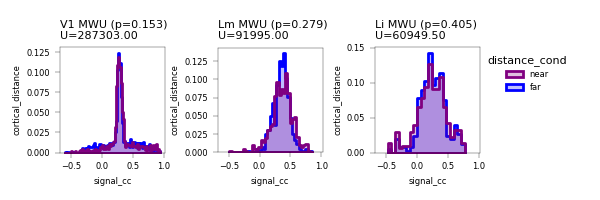

0.9829311370849609 0.0010284637100994587
0.9793841242790222 1.3354644579521846e-05
0.9742688536643982 1.0135158845514525e-06
0.9881742596626282 0.001636840752325952
0.8811284899711609 1.4109263733066392e-21
0.9390884041786194 1.9744797085737708e-18


In [170]:
# y_var='signal_cc'
print(y_var, dist_var)
near_bins = [0,2] if dist_var=='rf_distance' else [0, 25, 50, 75]
far_bins = [4, 6] if dist_var=='rf_distance' else [100, 125, 150, 175]
# near_bins = [0,2] if dist_var=='rf_distance' else [0, 25]
# far_bins = [4, 6] if dist_var=='rf_distance' else [50, 75]

col1='purple'
col2='blue'
curr_dist_colors = dict((k, v) for k, v in zip(['near', 'far'], [col1, col2]))

v1df = plotd[plotd['%s_label' % dist_var].isin(near_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var]].copy()
v2df = plotd[plotd['%s_label' % dist_var].isin(far_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var]].copy()
print(len(v1df), len(v2df))
v1df['distance_cond'] = 'near'
v2df['distance_cond'] = 'far'
dist_df = pd.concat([v1df, v2df], axis=0, ignore_index=True)

fig, axn = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2))

for va, vg in dist_df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    v1 = vg[vg.distance_cond=='near'][y_var].values
    v2 = vg[vg.distance_cond=='far'][y_var].values
    w, pvalue = spstats.shapiro(v1)
    print(w, pvalue)
    w, pvalue = spstats.shapiro(v2)
    print(w, pvalue)
    sns.histplot(x=y_var, data=vg, hue='distance_cond', ax=ax,
                 palette=curr_dist_colors, cumulative=False, common_norm=False,
                stat='probability', element='step', lw=2)
    ax.set_ylabel(dist_var)
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left',
                  frameon=False)
    else:
        ax.legend_.remove()
#     ax1.hist(v1, bins=10, histtype='bar', ec='k', color=col1)
#     ax2.hist(v2, bins=10, histtype='bar', ec='k', color=col2)
#     wts1 = np.ones_like(v1)/len(v1)
#     ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1)
#     wts2 = np.ones_like(v2)/len(v2)
#     ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
#             weights=wts2)
#     for ax in fig.axes:
#         ax.set_xlabel(y_var)
    ax.set_box_aspect(1)
    U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
    ax.set_title('%s MWU (p=%.3f)\nU=%.2f' % (va, p, U), loc='left')
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.8, bottom=0.2, top=0.8)

# Fit decay

In [227]:
equal_bins=False
n_bins=10
# Split distances into X um bins
ctx_maxdist = 500 #500
df, dist_lut = cr.get_bins_and_cut(ccdist[ccdist.cortical_distance<=ctx_maxdist], 
                                   ctx_step=10, overlap_step=0.02, rf_step=0.5)
dist_vars = ['cortical_distance', 'rf_distance']

<IPython.core.display.Javascript object>


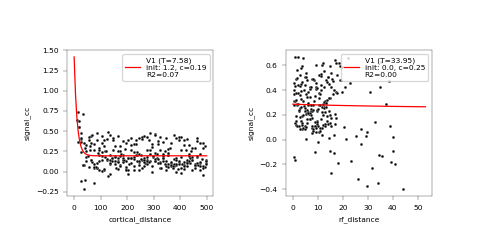

init        1.223597
tau         7.584664
constant    0.194982
R2          0.065249
dtype: float64
init         0.031640
tau         33.945868
constant     0.254986
R2           0.000197
dtype: float64


In [228]:
vg = 'V1'
vg = df[(df.visual_area==va)].copy() #.dropna()
fit_sites=True
metric = 'signal_cc'
min_npairs=3
use_binned=False
ymax=None

fig, axn = pl.subplots(1, 2, figsize=(6,3))
# plot
for ax, dist_var in zip(axn.flat, dist_vars):
    x_var = '%s_label' % dist_var
    curr_maxdist = dist_lut[dist_var]['max_dist']
    cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
    if fit_sites:
        meas_cc = vg.groupby(cnt_groups).median().reset_index() #.dropna()
    else:
        meas_cc = vg.copy()
    sns.scatterplot(x=dist_var, y=metric, data=meas_cc, s=5, color='k', ax=ax)
    # fit
    nsamples_per = cr.count_nsamples_per_bin(vg, cnt_groups, 
                                             min_npairs=min_npairs)
    res_, xvals, yvals = cr.sample_bins_and_fit(vg, nsamples_per, cnt_groups, 
                                    to_quartile=dist_var, metric=metric, 
                                    fit_sites=fit_sites,
                                    use_binned=use_binned, normalize_x=True, 
                                    func='halflife', estimator='median',
                                    resample=True, ymax=ymax)
    print(res_)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        xvals = np.linspace(0, curr_maxdist, 100)
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label, lw=1)
    ax.legend()
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)

# Bootstrap decay fit

In [253]:
ctx_maxdist = 500
df, dist_lut = cr.get_bins_and_cut(ccdist[ccdist.cortical_distance<=ctx_maxdist], 
                                   ctx_step=10, overlap_step=0.02, rf_step=1.0)

In [280]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='signal_cc'
to_quartile='cortical_distance'
ymax=None # for pearsons, sets to -2, 2 (should be -1, 1)
# --------------------------------------------------
cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=500
# Fit function
resdf = cr.bootstrap_fitdecay(df, use_binned=use_binned,fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         n_iterations=n_iterations, normalize_x=True, ymax=ymax)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
(647, 6)


init: 428/500 iters too big
init: 365/500 iters too small
tau: 0/500 iters too big
tau: 0/500 iters too small


<IPython.core.display.Javascript object>


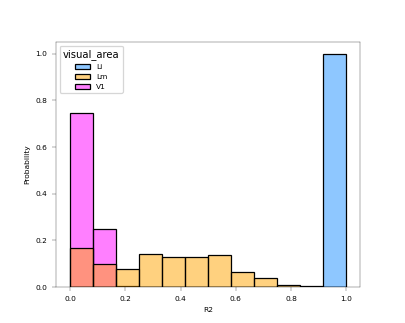

In [281]:
ymin, ymax = (-1, 1)
xmin, xmax = (0, dist_lut[to_quartile]['max_dist'])
# ------------------------------------------------
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

print("init: %i/%i iters too big" % (resdf[resdf.init>ymax].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<ymin].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>xmax].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.tau<xmin].shape[0], n_iterations))

fig, ax =pl.subplots()
sns.histplot(x='R2', data=resdf.dropna(), ax=ax, hue='visual_area', 
             palette=area_colors, stat='probability', common_norm=False)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [282]:
resdf.shape

(1474, 6)

In [283]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=ymax+0.2) & (resdf['init']>=ymin-0.2) 
                   & (resdf['tau']<=xmax) & (resdf['tau']>=xmin)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=ymax) & (resdf['init']>=ymin) 
                   & (resdf['tau']<=xmax) & (resdf['tau']>=xmin)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(1474, 6) (681, 6)


cortical distance (um)


<IPython.core.display.Javascript object>


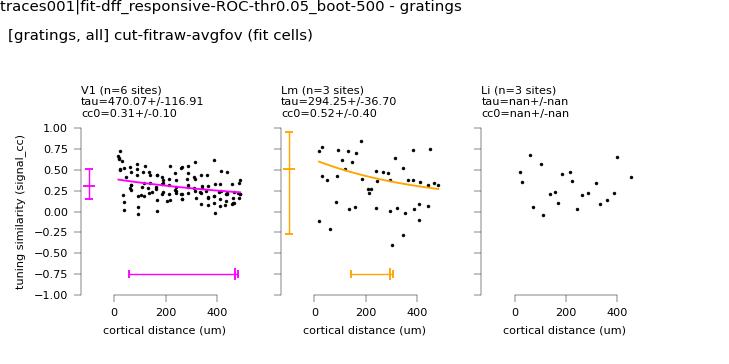

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta cortical_distance_curves_v_signal_cc_all


In [284]:
if xmax==1:
    x_pos = xmin-0.1
    xlabel='%s (frac.)' % to_quartile
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -10
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
y_pos = ymin+0.25
ylabel='tuning similarity (%s)' % metric
ylim=None #(ymin-0.2, ymax+0.4)

print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, finalres,  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 1), xlabel=xlabel, ylabel=ylabel)
fig.text(0.01, 0.9, '[%s, %s] %s (fit cells)' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = 'bootfit_curves_%s_v_%s_%s' % (to_quartile, metric, select_stimuli)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [285]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta'

<IPython.core.display.Javascript object>


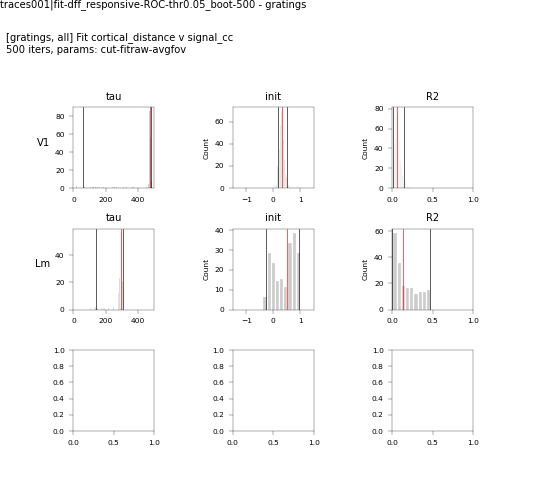

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta param_distns_cortical_distance_v_signal_cc_all


In [286]:
if to_quartile=='area_overlap':
    tau_lim = 1
else:
    #tau_lim=1200 if to_quartile=='cortical_distance' else dist_lut['']
    tau_lim = dist_lut[dist_var]['max_dist']
    
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
for va, rd_ in finalres.groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
for ax in axn.flat:
    ax.set_box_aspect(1)
    
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, hspace=0.5, wspace=0.5, top=0.8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.9, "[%s, %s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, select_stimuli, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_v_%s_%s' % (to_quartile, metric, select_stimuli)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [1043]:
scatter_kws={'s':2}
ctx_limits = {'near': {'upper_lim': 50, 'lower_lim': None},
              'intermediate': {'upper_lim': 250, 'lower_lim': 100},
              'far': {'upper_lim': None, 'lower_lim': 300}}

In [1046]:
# plotd = angdists.copy() #.dropna().copy()
#vg = plotd[plotd.visual_area=='V1']
s_=[]
for va, vg in angdists.groupby('visual_area'):
    for di, dist_cond in enumerate(['near', 'intermediate', 'far']):
        df_ = cr.get_bins_within_limits(vg, bin_name=dist_var, 
                                upper_lim=ctx_limits[dist_cond]['upper_lim'],
                                lower_lim=ctx_limits[dist_cond]['lower_lim'])
        v1 = df_['cortical_distance'].values
        v2 = df_[y_var].values
        curr_stat = pg.mwu(v1, v2)
        curr_stat['distance_cond'] = dist_cond
        curr_stat['visual_area'] = va
        curr_stat['with_rfs'] = with_rfs
        s_.append(curr_stat)
statsdf = pd.concat(s_, axis=0).reset_index(drop=True)


In [1047]:
import statsmodels


rej, pcorrs, alphaSid, alphaBonf = statsmodels.stats.multitest.multipletests(statsdf['p-val'], 
        alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

posthoc_df = pd.DataFrame({'reject': rej, 'p_corrected': pcorrs})

In [1048]:
pd.concat([statsdf, posthoc_df], axis=1)

U-val       tail          p-val       RBC      CLES distance_cond  \
0        5.0  two-sided   1.436721e-01  0.600000  0.200000          near   
1     1296.0  two-sided   3.021244e-13 -1.000000  1.000000  intermediate   
2      529.0  two-sided   6.566437e-09 -1.000000  1.000000           far   
3       31.0  two-sided   1.619724e-01  0.380000  0.310000          near   
4     4225.0  two-sided   7.943467e-23 -1.000000  1.000000  intermediate   
5    40804.0  two-sided   1.058006e-67 -1.000000  1.000000           far   
6     3411.0  two-sided   4.021877e-02  0.176186  0.411907          near   
7   697225.0  two-sided  3.310754e-274 -1.000000  1.000000  intermediate   
8  3389281.0  two-sided   0.000000e+00 -1.000000  1.000000           far   

  visual_area  with_rfs  reject    p_corrected  
0          Li     False   False   1.616311e-01  
1          Li     False    True   5.438239e-13  
2          Li     False    True   9.849656e-09  
3          Lm     False   False   1.619724e-01  
4          Lm     False    True   1.787280e-22  
5          Lm     False    True   3.174018e-67  
6          V1     False   False   5.170985e-02  
7          V1     False    True  1.489839e-273  
8          V1     False    True   0.000000e+00

In [1049]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


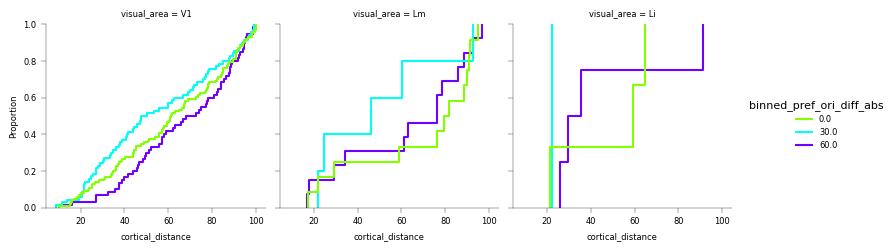

In [1055]:
cmap='hsv'
plotd = angdists[angdists.cortical_distance<=100]
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=dist_var, height=2.5,
           hue='binned_%s' % hue_label, palette=cmap, kind='ecdf')

In [1056]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


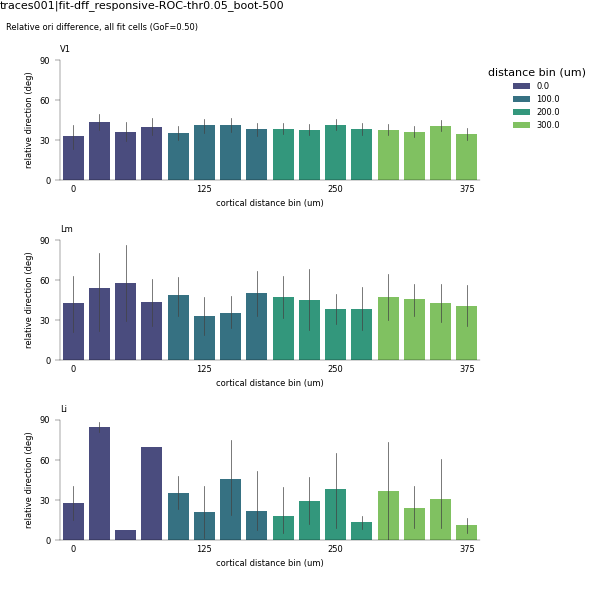

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta relative_ori_hue-distbin_max400_gof-0.50


In [1058]:
stim_str='ori'
y_var = 'pref_%s_diff_abs' % stim_str 
x_var='cortical_distance_label'
# ---------
hue_label = 'distance_group_label'
palette='viridis'
ylim = (0, 90) if stim_str=='ori' else (0, 180)
# Ticks
min_npairs=0 #10
max_dist = 400
sorted_x_vars = [k for k, v in angdists.groupby(x_var) if k<max_dist]
# Colors
vals_ = grp_bins[grp_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
grp_colors = dict((k, v) for k, v in zip(vals_, cols_))

# plot
plotd = angdists[(angdists.cortical_distance<=max_dist)].copy()
fg = sns.FacetGrid(data=plotd, row='visual_area', row_order=['V1', 'Lm','Li'],
                   height=2, aspect=3, sharex=False, sharey=False)
fg.map(sns.barplot, x_var, y_var, hue_label, palette=grp_colors,
                   dodge=False, errwidth=0.5, order=sorted_x_vars)
fg.set_titles("{row_name}", loc='left')  # use this argument literally
for ax in fg.axes.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('cortical distance bin (um)')
    ax.set_xticklabels([int(i) if i in sorted_x_vars[0::5] else '' \
                            for i in sorted_x_vars])
    ax.set_ylim(ylim)
    ax.set_yticks(np.linspace(0, ylim[-1], 4))
    ax.set_ylabel('relative direction (deg)')
    ax.set_title('')
    #ax.set_box_aspect(0.75)
ax=fg.axes.flat[0]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='distance bin (um)')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)

fg.fig.text(0.01, 0.95, 'Relative %s difference, all fit cells (GoF=%.2f)' \
         % (stim_str, gof_thr))
pplot.label_figure(fg.fig, data_id)

figname = 'relative_%s_hue-distbin_max%i_gof-%.2f' % (stim_str, max_dist, gof_thr)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


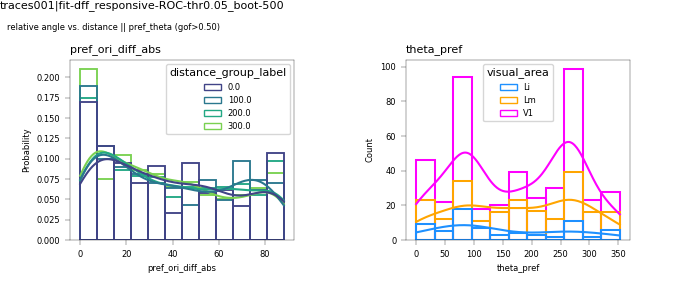

Text(0.01, 0.9, 'relative angle vs. distance || pref_theta (gof>0.50)')

In [1060]:
fig, axn = pl.subplots(1, 2, figsize=(7,3))
ax=axn[0]
sns.histplot(x='pref_ori_diff_abs', data=vg, cumulative=False, #bins=1000,
            hue=hue_label, fill=False,common_norm=False, ax=ax, #element='poly',
            kde=True, stat='probability', palette=grp_colors)
ax.set_title(y_var, loc='left', fontsize=8)

ax=axn[1]
sns.histplot(x='theta_pref', data=finaldf,
            hue='visual_area', fill=False, common_norm=False, ax=ax,
            kde=True, stat='count', palette=area_colors)
ax.set_title('theta_pref', loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8, bottom=0.2)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'relative angle vs. distance || pref_theta (gof>%.2f)' % gof_thr)


<IPython.core.display.Javascript object>


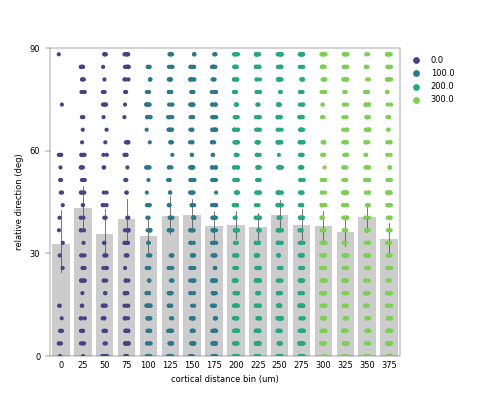

In [1061]:
step=25
ctx_dist_bins = np.arange(0, 1000+step, step)
angdists = cr.cut_bins(angdists, ctx_dist_bins, 'cortical_distance')

max_dist = 400
vg = plotd[(plotd.cortical_distance<=max_dist) 
              & (plotd.visual_area=='V1')].copy()

fig, ax = pl.subplots()
sns.barplot(x=x_var,y=y_var, data=vg, ax=ax,#hue=hue_label,ax=ax,
            dodge=False, errwidth=0.5, order=sorted_x_vars, color=[0.8]*3)
sns.stripplot(x=x_var, y=y_var, data=vg, ax=ax,#hue=hue_label,ax=ax,
            dodge=False, order=sorted_x_vars, jitter=True, size=3,
             hue=hue_label, palette=grp_colors)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
         markerscale=0.5)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('cortical distance bin (um)')
#ax.set_xticks(np.arange(0, len(sorted_x_vars)))
ax.set_xticklabels([int(i) for i in sorted_x_vars])
ax.set_ylim(ylim)
ax.set_yticks(np.linspace(0, ylim[-1], 4))
ax.set_ylabel('relative direction (deg)')
ax.set_title('')

pl.subplots_adjust(left=0.1, right=0.8)

0.9227790236473083 6.612710379272357e-10
0.9198457598686218 3.9524895129820076e-15


<IPython.core.display.Javascript object>


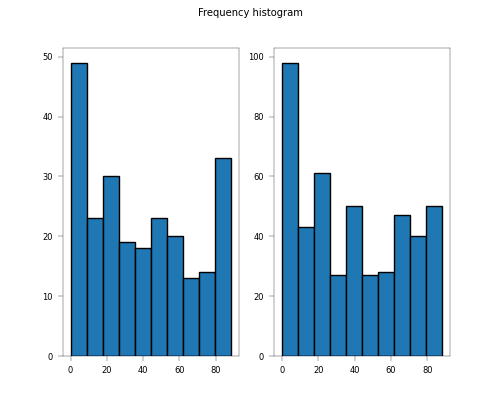

MannwhitneyuResult(statistic=57500.0, pvalue=0.8451463530545344)


In [1063]:
va='V1'
#vg = plotd[(plotd.visual_area==va) ] #& (plotd.distance_label==200)]
v1 = vg[vg.distance_group_label==0][y_var].values
v2 = vg[vg.distance_group_label==100][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)

w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2) = pl.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k') 
ax2.hist(v2, bins=10, histtype='bar', ec='k') 
print(spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided'))


In [ ]:
fig, ax = pl.sub

In [614]:
from scipy.stats import kendalltau

In [609]:
va='V1'
vg = plotd[(plotd.visual_area==va) ] #& (plotd.distance_label==200)]

print(pg.anova(data=vg[vg.distance_group_label==0], 
         dv=y_var, between='cortical_distance_label'))
print(pg.anova(data=vg[vg.distance_group_label==100], 
         dv=y_var, between='cortical_distance_label'))

print(pg.anova(data=vg[vg.distance_group_label==200], 
         dv=y_var, between='cortical_distance_label'))

                    Source  ddof1  ddof2        F     p-unc       np2
0  cortical_distance_label      3    238  1.29504  0.276777  0.016062
                    Source  ddof1  ddof2         F     p-unc       np2
0  cortical_distance_label      3    467  1.085555  0.354828  0.006925
                    Source  ddof1  ddof2         F    p-unc       np2
0  cortical_distance_label      3    697  0.574152  0.63215  0.002465


In [190]:
va='Lm'
vg = plotd[(plotd.visual_area==va) ] #& (plotd.distance_label==200)]

pg.anova(data=vg, dv=y_var, between='binned_cortical_distance_label')


Source  ddof1  ddof2         F    p-unc       np2
0  binned_cortical_distance_label     19    198  1.356291  0.15261  0.115161

In [182]:
va='V1'
vg=plotd[plotd.visual_area==va]

pg.welch_anova(data=vg, dv=y_var, 
         between=['binned_cortical_distance_label'])

Source  ddof1  ddof2   F     p-unc       np2
0  binned_cortical_distance_label    NaN    NaN NaN  0.202801  0.009249

In [183]:
# pg.pairwise_ttests(dv=y_var, between='binned_cortical_distance_label',# subject='Subject',
#                    data=vg, padjust='holm')

# Only look at MOST fit cells 

In [153]:
min_ncells=5
curr_gof=0.66
fitdists = cr.aggregate_angular_dists(finaldf[finaldf['gof']>=curr_gof], min_ncells=5)

too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190602_JC091_fov1
too few cells: Li, 20190609_JC099_fov1
too few cells: Li, 20190614_JC091_fov1
too few cells: Li, 20191018_JC113_fov1
too few cells: Lm, 20190306_JC061_fov2
too few cells: V1, 20190512_JC083_fov1


In [156]:
fitdists.groupby('visual_area').count()

neuron_pair  cell_1  cell_2  pref_dir_diff  pref_dir_diff_abs  \
visual_area                                                                  
Lm                  1062    1062    1062           1062               1062   
V1                  2522    2522    2522           2522               2522   

             pref_ori_diff  pref_ori_diff_abs  rf_angle_diff  \
visual_area                                                    
Lm                    1062               1062             81   
V1                    2522               2522            574   

             rf_angle_diff_abs  response_pref  rf_distance  max_ecc  min_ecc  \
visual_area                                                                    
Lm                          81           1062           81       81       81   
V1                         574           2522          574      574      574   

             cortical_distance  datakey  n_cells  
visual_area                                       
Lm                          81     1062     1062  
V1                         574     2522     2522

In [733]:
fitdf = fitdists[fitdists.visual_area.isin(['V1', 'Lm', 'Li'])].copy()

step=12.5
ctx_dist_bins = np.arange(0, 1000+step, step)
fitdf = cr.cut_bins(fitdf, ctx_dist_bins, 'cortical_distance')

step=50
grp_bins = np.arange(0, 1000+step, step)
fitdf['distance_group'] = pd.cut(fitdf['cortical_distance'], \
                                                grp_bins, include_lowest=True,
                                                labels=grp_bins[0:-1])
fitdf['distance_group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in fitdf['distance_group'].values]

<IPython.core.display.Javascript object>


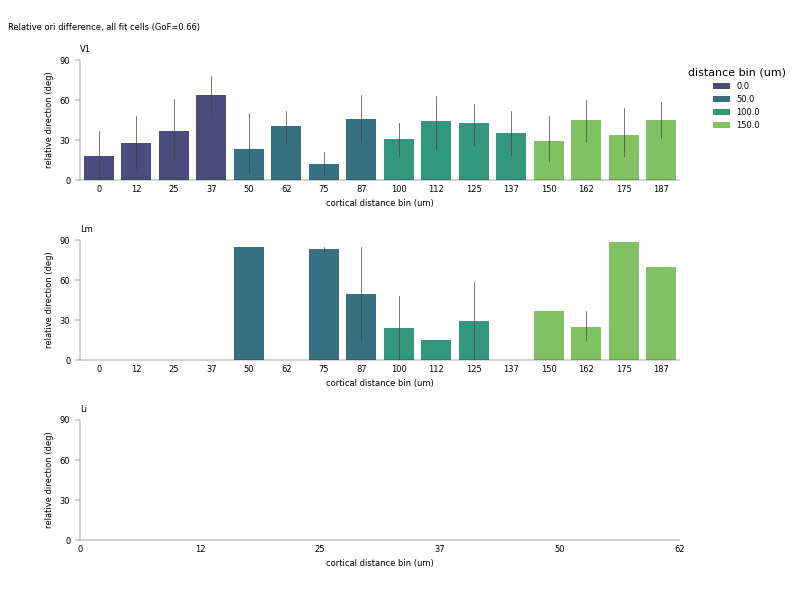

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta relative_ori_hue-distbin_max200_BESTFIT


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


In [734]:
stim_str='ori'
y_var = 'pref_%s_diff_abs' % stim_str 
hue_label = 'distance_group_label'
x_var='cortical_distance_label'
palette='viridis'
ylim = (0, 90) if stim_str=='ori' else (0, 180)
# Ticks
min_npairs=0 #10
max_dist = 200
sorted_x_vars = [k for k, v in fitdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))
# plot
plotd = fitdf[(fitdf.cortical_distance<=max_dist)].copy()
fg = sns.FacetGrid(data=plotd, row='visual_area', row_order=['V1', 'Lm', 'Li'],
                   height=2, aspect=4, sharex=False, sharey=False)
fg.map(sns.barplot, x_var, y_var, hue_label, palette=dist_colors,
      dodge=False, errwidth=0.5, order=sorted_x_vars)
#[pl.setp(ax.texts, text="") for ax in fg.axes.flat] 
fg.set_titles("{row_name}", loc='left')  # use this argument literally

for ax in fg.axes.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('cortical distance bin (um)')
    #ax.set_xticks(np.arange(0, len(sorted_x_vars)))
    ax.set_xticklabels([int(i) for i in sorted_x_vars])
    ax.set_ylim(ylim)
    ax.set_yticks(np.linspace(0, ylim[-1], 4))
    ax.set_ylabel('relative direction (deg)')
    ax.set_title('')
ax=fg.axes.flat[0]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='distance bin (um)')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)
fg.fig.text(0.01, 0.95, 'Relative %s difference, all fit cells (GoF=%.2f)' \
         % (stim_str, curr_gof))

# pplot.label_figure(fg.fig, data_id)
# figname = 'relative_%s_by_hue_distbin_BESTFIT' % stim_str
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

figname = 'relative_%s_hue-distbin_max%i_BESTFIT' % (stim_str, max_dist)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


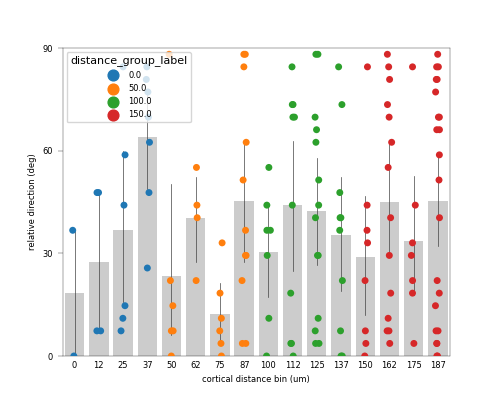

Text(0.5, 1.0, '')

In [736]:
# step=25
# ctx_dist_bins = np.arange(0, 1000+step, step)
# #fitdf = cr.cut_bins(fitdf, ctx_dist_bins, 'cortical_distance')

# max_dist = 200
# vg = fitdf[(fitdf.cortical_distance<=max_dist) & (fitdf.visual_area=='V1')].copy()

vg = plotd[plotd.visual_area=='V1']
fig, ax = pl.subplots()
sns.barplot(x=x_var,y=y_var, data=vg, ax=ax,#hue=hue_label,ax=ax,
            dodge=False, errwidth=0.5, order=sorted_x_vars, color=[0.8]*3)
sns.stripplot(x=x_var,y=y_var, data=vg, ax=ax,#hue=hue_label,ax=ax,
            dodge=False, order=sorted_x_vars, hue=hue_label)

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('cortical distance bin (um)')
#ax.set_xticks(np.arange(0, len(sorted_x_vars)))
ax.set_xticklabels([int(i) for i in sorted_x_vars])
ax.set_ylim(ylim)
ax.set_yticks(np.linspace(0, ylim[-1], 4))
ax.set_ylabel('relative direction (deg)')
ax.set_title('')

# ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
#          title='distance bin (um)')
# pl.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)
# fig.text(0.01, 0.95, 'Relative %s difference, all fit cells (GoF=%.2f)' \
#          % (stim_str, curr_gof))


0.9227790236473083 6.612710379272357e-10
0.9091578722000122 7.562134807237442e-10


<IPython.core.display.Javascript object>


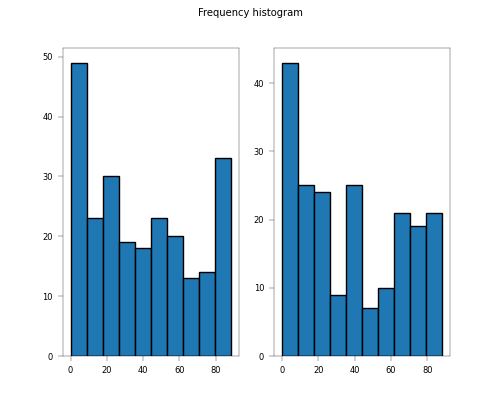

MannwhitneyuResult(statistic=25421.0, pvalue=0.5869356522114765)


In [731]:
va='V1'
#vg = plotd[(plotd.visual_area==va) ] #& (plotd.distance_label==200)]
v1 = vg[vg['distance_group_label']<=50][y_var].values
v2 = vg[vg['distance_group_label']==100][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)

w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2) = pl.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k') 

ax2.hist(v2, bins=10, histtype='bar', ec='k') 
print(spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided'))


<IPython.core.display.Javascript object>


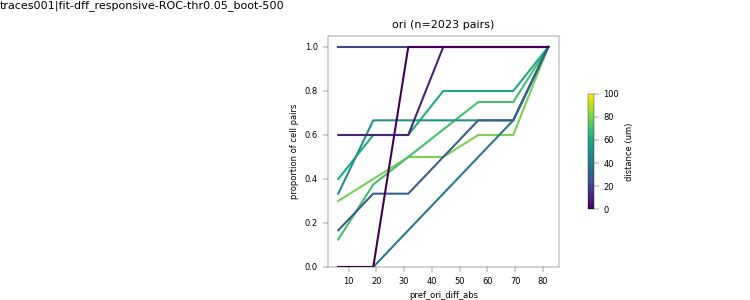

In [729]:
cmap = 'viridis'
min_npairs =0
hue_label = 'cortical_distance'
cbar_label = 'distance (um)' if hue_label=='cortical_distance' else None
# ------------------------------------------
stim_str = 'ori'
x_var = 'pref_%s_diff_abs' % stim_str
# --------------------------------------------
ctx_maxdist=100
ctx_stepsize=10
plotd = fitdf[(fitdf.cortical_distance<=ctx_maxdist)].copy()
hue_bins = np.arange(0, ctx_maxdist, ctx_stepsize)

fig, ax = pl.subplots(figsize=(7.5,3))
df_ = cr.get_binned_X(plotd, x_label=hue_label, x_bins=hue_bins, 
                     min_npairs=0, labels=hue_bins[0:-1])
g = sns.histplot(x=x_var, hue='binned_%s' % hue_label, data=df_, ax=ax,
        cumulative=True, fill=None, element='poly', stat='probability',
        common_norm=False, palette=cmap, hue_norm=(0, ctx_maxdist), 
        line_kws={'lw': 2, 'alpha': 0.5})
ax.legend_.remove()
ax.set_box_aspect(1); #ax.set_xlim([-1, 1]); ax.set_ylim([0, 1]);
n_pairs = len(vg['neuron_pair'].unique())
ax.set_title('%s (n=%i pairs)' % (stim_str, n_pairs))
ax.set_ylabel('proportion of cell pairs');
#if not shared_colorbar:
norm = pl.Normalize(0, ctx_maxdist)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=cbar_label)
# Colorbar
pplot.label_figure(fig, data_id)

In [664]:
import pingouin as pg

In [669]:
va='V1'
vg = plotd[(plotd.visual_area==va) & (plotd.distance_group_label==0)].copy()

pg.anova(data=vg, dv=y_var, 
         between=['cortical_distance_label'])


Source  ddof1  ddof2         F     p-unc       np2
0  cortical_distance_label      3     15  2.810701  0.075166  0.359853

In [666]:
y_var

'pref_ori_diff_abs'

0.9456252455711365 0.0008418367942795157
0.9023074507713318 1.6436372263228805e-08


<IPython.core.display.Javascript object>


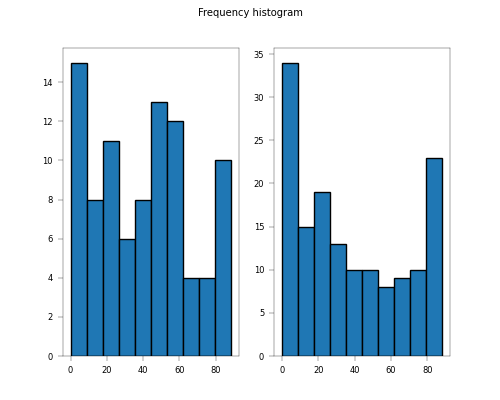

MannwhitneyuResult(statistic=7260.0, pvalue=0.46071304697840754)


In [726]:
va='V1'
vg = plotd[(plotd.visual_area==va) ] #& (plotd.distance_label==200)]
v1 = vg[vg['distance_group_label']==0][y_var].values
v2 = vg[vg['distance_group_label']==50][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)

w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2) = pl.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k') 
ax2.hist(v2, bins=10, histtype='bar', ec='k') 
print(spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided'))


In [653]:
pg.anova(data=vg[vg.distance_group_label==0], 
         dv=y_var, between='cortical_distance_label')


Source  ddof1  ddof2         F     p-unc      np2
0  cortical_distance_label      1     17  4.118277  0.058378  0.19501

In [599]:
pg.anova(data=vg[vg.distance_group_label==0], 
         dv=y_var, between='cortical_distance_label')
pg.anova(data=vg[vg.distance_group_label==50], 
         dv=y_var, between='cortical_distance_label')
pg.anova(data=vg[vg.distance_group_label==100], 
         dv=y_var, between='cortical_distance_label')

Source  ddof1  ddof2         F     p-unc       np2
0  cortical_distance_label      3     23  2.315431  0.102424  0.231958

In [591]:
for vi, vv in vg.groupby(['distance_group_label']):
    vg.loc[vv.index, 'subject'] = np.arange(0, len(vv))
    

In [592]:
pg.mixed_anova(dv=y_var, between='cortical_distance_label', subject='subject',
               within='distance_group_label',data=vg)

Source            SS  DF1  DF2           MS         F  \
0  cortical_distance_label  15516.647894   15   35  1034.443193  0.512804   
1     distance_group_label   1690.879218    3  105   563.626406  1.755282   
2              Interaction  -1690.879218   45  105   -37.575094 -0.117019   

      p-unc       np2       eps  
0  0.916413  0.180175       NaN  
1  0.160289  0.047756  0.833496  
2  1.000000 -0.052799       NaN

## Split by DSI vs. ASI vs. Neither

In [203]:
finaldf.groupby('visual_area').count()

response_pref  response_null  theta_pref  sigma  response_offset  \
visual_area                                                                     
Li                      70             70          70     70               70   
Lm                     219            219         219    219              219   
V1                     443            443         443    443              443   

             asi  dsi  circvar_asi  circvar_dsi  r2_gratings  ...  \
visual_area                                                   ...   
Li            70   70           70           70           70  ...   
Lm           219  219          219          219          219  ...   
V1           443  443          443          443          443  ...   

             eccentricity  animalid_y  fov_y  session_y  fov_xpos  \
visual_area                                                         
Li                    292         292    292        292       292   
Lm                    211         211    211        211       211   
V1                    678         678    678        678       678   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    292       292           292     292     292  
Lm                    211       211           211     211     211  
V1                    678       678           678     678     678  

[3 rows x 58 columns]

<IPython.core.display.Javascript object>


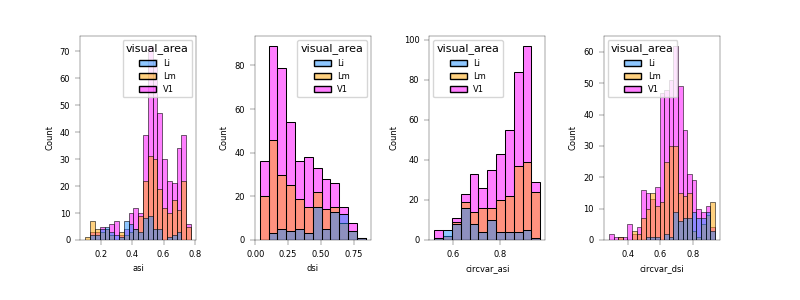

In [204]:
plot_params = ['asi', 'dsi', 'circvar_asi', 'circvar_dsi']
fig, axn = pl.subplots(1, len(plot_params), figsize=(8,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, hue='visual_area', palette=area_colors, ax=ax,
                common_norm=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5)

# Most selective cells only

In [206]:
min_ncells=2
asi_lim=0.4
dsi_lim=0.4

gof=0.05
dsi_df = finaldf[(finaldf.dsi>=dsi_lim) & (finaldf.gof>gof)].copy()
asi_df = finaldf[(finaldf.asi>=asi_lim) & (finaldf.gof>gof)].copy()
# asi_lim=0.6
# dsi_lim=0.8
# dsi_df = finaldf[(finaldf.circvar_dsi>=dsi_lim) & (finaldf.gof>=0.5)].copy()
# asi_df = finaldf[(finaldf.circvar_asi>=asi_lim) & (finaldf.gof>=0.5)].copy()
asi_df.groupby(['visual_area']).count()

response_pref  response_null  theta_pref  sigma  response_offset  \
visual_area                                                                     
Li                      39             39          39     39               39   
Lm                     191            191         191    191              191   
V1                     404            404         404    404              404   

             asi  dsi  circvar_asi  circvar_dsi  r2_gratings  ...  \
visual_area                                                   ...   
Li            39   39           39           39           39  ...   
Lm           191  191          191          191          191  ...   
V1           404  404          404          404          404  ...   

             eccentricity  animalid_y  fov_y  session_y  fov_xpos  \
visual_area                                                         
Li                     12          12     12         12        12   
Lm                     51          51     51         51        51   
V1                    197         197    197        197       197   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                     12        12            12      12      12  
Lm                     51        51            51      51      51  
V1                    197       197           197     197     197  

[3 rows x 58 columns]

In [207]:
asi_diffs = cr.aggregate_angular_dists(asi_df, min_ncells=2)
dsi_diffs = cr.aggregate_angular_dists(dsi_df, min_ncells=2)

too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20191111_JC120_fov1
too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190617_JC099_fov1
too few cells: Lm, 20191105_JC117_fov1


In [209]:
dsi_diffs['selectivity'] = 'dir'
asi_diffs['selectivity'] = 'ori'
splitdf0 = pd.concat([dsi_diffs, asi_diffs], axis=0, ignore_index=True)

In [864]:
curr_areas = ['V1', 'Lm', 'Li']
splitdf = splitdf0[(splitdf0.visual_area.isin(curr_areas))].dropna().copy()

ctx_step=50
ctx_dist_bins = np.arange(0, 1000+ctx_step, ctx_step)
splitdf = cr.cut_bins(splitdf, ctx_dist_bins, 'cortical_distance')

# splitdf['binned_cortical_distance'] = pd.cut(splitdf['cortical_distance'], \
#                                                 ctx_dist_bins, include_lowest=True,
#                                                 labels=ctx_dist_bins[0:-1])
# splitdf['binned_cortical_distance_label'] = [int(d) if not np.isnan(d) else d \
#                                 for d in splitdf['binned_cortical_distance'].values]
grp_step=100
grp_bins = np.arange(0, 1000+grp_step, grp_step)
splitdf['distance_group'] = pd.cut(splitdf['cortical_distance'], \
                                                grp_bins, include_lowest=True,
                                                labels=grp_bins[0:-1])
splitdf['distance_group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in splitdf['distance_group'].values]
# Ticks
min_npairs=0 #10
max_dist = 800
sorted_x_vars = [k for k, v in splitdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = grp_bins[grp_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
grp_colors = dict((k, v) for k, v in zip(vals_, cols_))

<IPython.core.display.Javascript object>


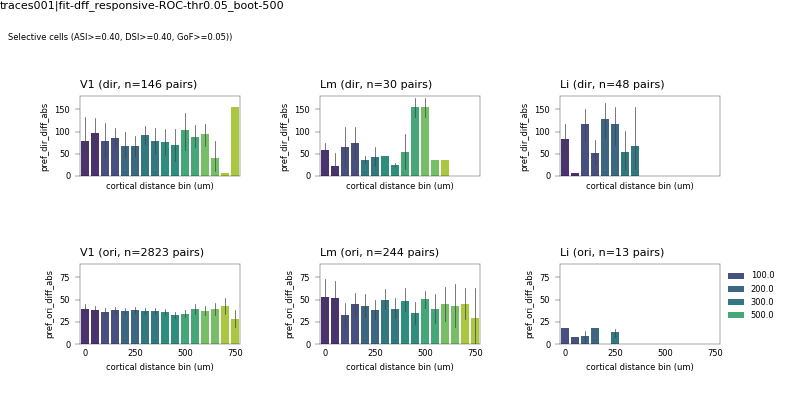

In [865]:
# bin_lut = {'pref_ori_diff_abs': np.linspace(0, 90, 4), #7), #7),
#            'pref_dir_diff_abs': np.linspace(0, 180, 7), #7),}
y_var = 'pref_ori_diff_abs'
hue_label='distance_group_label'

# hue_bins = np.linspace(0, 90, 7) if hue_label=='pref_ori_diff_abs'\
#                 else np.linspace(0, 180, 7)
#hue_bins = bin_lut[hue_label]
min_npairs=0 #10
x_var='cortical_distance_label'

plotd = splitdf[(splitdf.cortical_distance<=max_dist)].copy()
fig, axn = pl.subplots(2,3, figsize=(8,4), sharex=True, sharey=False)
for va, vg in plotd.groupby('visual_area'):
    vi=visual_areas.index(va)
    for di, (stim_str, sg) in enumerate(vg.groupby('selectivity')):
        ax=axn[di, vi]
        # bins
        y_var = 'pref_%s_diff_abs' % stim_str
        ylim = (0, 90) if stim_str=='ori' else (0, 180)
        n_pairs = len(sg['neuron_pair'].unique())
        ax.set_title("%s (%s, n=%i pairs)" % (va, stim_str, n_pairs), loc='left')
        g = sns.barplot(x=x_var, y=y_var, data=sg, ax=ax, 
                    errwidth=0.5, hue=hue_label, palette=grp_colors,
                    zorder=-1000, dodge=False)
        ax.legend_.remove()
        ax.set_box_aspect(0.5)
        ax.set_ylim(ylim)
        ax.set_xticks(np.arange(0, len(sorted_x_vars)))
        ax.set_xticklabels([int(i) if i in sorted_x_vars[0::5] else '' \
                                for i in sorted_x_vars])
        ax.set_xlabel('cortical distance bin (um)')
        ax.tick_params(which='both', axis='x', size=0)
axn.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.8, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.9, 'Selective cells (ASI>=%.2f, DSI>=%.2f, GoF>=%.2f))'
        % (asi_lim, dsi_lim, gof))

pplot.label_figure(fig, data_id)
figname='relative_diffs_hue_bindist_SELECTIVE_dsi%.2f_asi%.2f' % (dsi_lim, asi_lim)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [676]:
max_dist=800
step=100
np.arange(0, max_dist+step, step)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800])

<IPython.core.display.Javascript object>


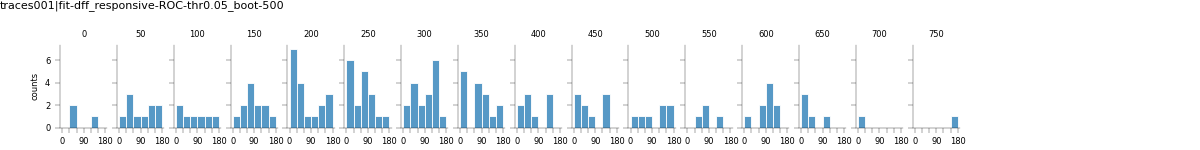

<IPython.core.display.Javascript object>


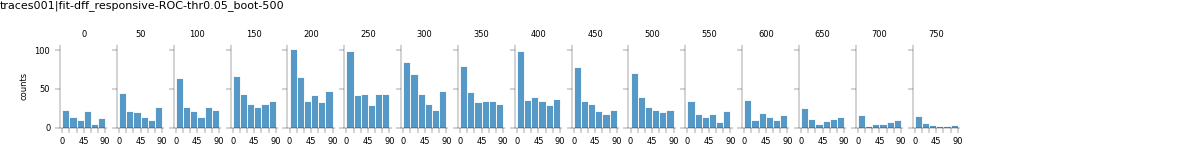

In [677]:
min_npairs=0 #10
palette='viridis'

max_dist=800
step=50
plot_bins = np.arange(0, max_dist+step, step)
splitdf['plot_bins'] = pd.cut(splitdf['cortical_distance'], plot_bins,
                             include_lowest=True, labels=plot_bins[0:-1])
plotd = splitdf[splitdf.visual_area=='V1']

for stim_str, sg in plotd.groupby('selectivity'):
    x_var = 'pref_%s_diff_abs' % stim_str
    max_val = 180 if stim_str=='dir' else 90
    step=30 if stim_str=='dir' else 15
    x_bins = np.arange(0, max_val+step, step)
    fg = sns.FacetGrid(col='plot_bins', data=sg,
                       height=1.5, aspect=0.5, sharey=True, sharex=False)
    fg.map(sns.histplot, x_var, bins=x_bins, edgecolor='w', stat='count')
    fg.set_titles("{col_name}")
    fg.axes[0, 0].set_ylabel('counts')
    fg.axes[0, 1].set_ylabel('counts')
    for ax in fg.axes.flat:
        ax.set_xticks(x_bins)
        ax.set_xticklabels([i if i in x_bins[0::3] else '' for i in x_bins])
    pl.subplots_adjust(left=0.05, right=0.8, bottom=0.15, top=0.7, 
                       wspace=0.2, hspace=0.5)

    fig.text(0.01, 0.85, '[%s] Selective cells (ASI>=%.2f, DSI>=%.2f, GoF>=%.2f))'
        % (stim_str, asi_lim, dsi_lim, gof))

    pplot.label_figure(fg.fig, data_id)
    figname = 'SELECTIVE_relative_%s_counts_by_dist' % stim_str
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [262]:
SDF = aggr.check_sdfs(NDATA['datakey'].unique(), experiment=experiment,
                      images_only=False,rename=False, 
                      return_incorrect=False, return_all=False)
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Checking gratings configs
Dist: rf_distance
Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Lm, 20191105_JC117_fov1)
5 datasets w wrong configs:
    ('Li', '20190522_JC089_fov1')
    ('Lm', '20190512_JC083_fov1')
    ('Lm', '20190513_JC078_fov1')
    ('V1', '20190511_JC083_fov1')
    ('V1', '20190512_JC083_fov1')
4 datasets w/out RF fits:
    ('Li', '20190314_JC070_fov1', 'gratings')
    ('Li', '20190315_JC070_fov2', 'gratings')
    ('Li', '20190321_JC070_fov2', 'gratings')
    ('Lm', '20190306_JC061_fov2', 'gratings')


In [270]:
ccdf = CORRS.dropna(axis=1)

# Combine with CC

In [980]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in ccdf.columns if k not in ign_cols]
# DF = pd.merge(angdists, ccdf, on=cc_cols, how='inner')
gof_thr=0.5

if gof_thr==0.5:
    DF = pd.merge(angdists, ccdf, on=cc_cols, how='inner')
elif gof_thr==0.66:
    DF = pd.merge(fitdists, ccdf, on=cc_cols, how='inner')

In [981]:
cc_cols

['cell_1',
 'cell_2',
 'neuron_pair',
 'cortical_distance',
 'visual_area',
 'datakey']

In [983]:
# def cut_bins(DF, bins, metric='cortical_distance'):
#     DF['binned_%s' % metric] = pd.cut(DF[metric], bins, include_lowest=True,
#                                                 labels=bins[0:-1])
#     DF['binned_%s' % metric] = [int(d) if not np.isnan(d) else d \
#                                 for d in DF['binned_%s' % metric].values]
#     return DF
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


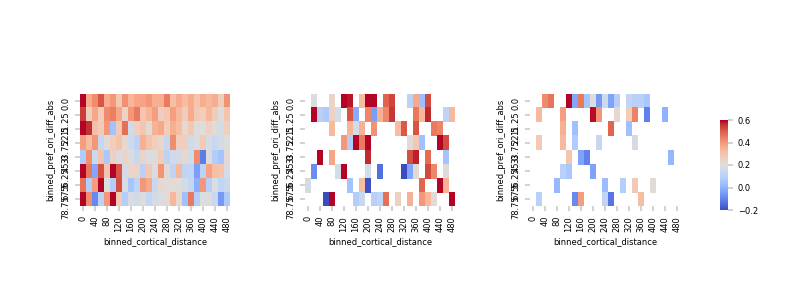

In [985]:
y_var = 'pref_ori_diff_abs'
x_var='cortical_distance'
hue_var = 'signal_cc'
vmin=-0.2
vmax=0.6
fig, axn = pl.subplots(1,3, figsize=(8,3))
cbar_ax = fig.add_axes([0.9, 0.3, 0.01, 0.3])

for i, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    means_ = vg.groupby(['binned_%s' % y_var, 'binned_%s' % x_var])\
               .mean().reset_index()
    hmat = means_.pivot('binned_%s' % y_var, 'binned_%s' % x_var, hue_var)
    sns.heatmap(hmat, cmap='coolwarm', ax=ax, vmin=vmin, vmax=vmax,
                cbar=i==0, cbar_ax=cbar_ax) #, center=0)
    ax.set_box_aspect(0.75)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


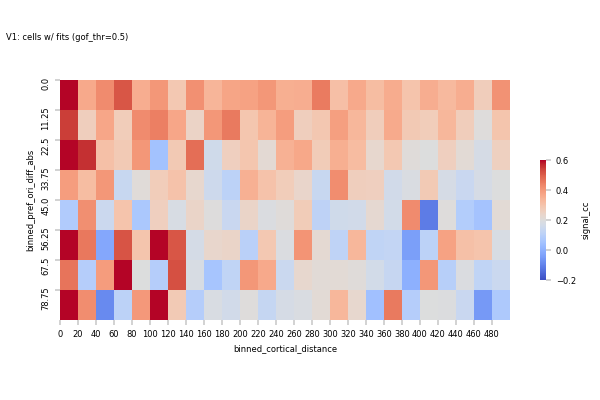

Text(0.01, 0.9, 'V1: cells w/ fits (gof_thr=0.5)')

In [986]:
y_var = 'pref_ori_diff_abs'
x_var='cortical_distance'
hue_var = 'signal_cc'
vmin=-0.2
vmax=0.6
vg = df[df.visual_area=='V1']
x_vals = [i for i, g in vg.groupby('binned_cortical_distance')]
y_vals = [i for i, g in vg.groupby('binned_pref_ori_diff_abs')]

fig, ax = pl.subplots(figsize=(6,4))
cbar_ax = fig.add_axes([0.9, 0.3, 0.01, 0.3])
means_ = vg.groupby(['binned_%s' % y_var, 'binned_%s' % x_var])\
           .mean().reset_index()
hmat = means_.pivot('binned_%s' % y_var, 'binned_%s' % x_var, hue_var)
g = sns.heatmap(hmat, cmap='coolwarm', ax=ax, vmin=vmin, vmax=vmax,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': hue_var})
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)
ax.set_xticks(np.arange(0, len(x_vals)))
ax.set_xticklabels(x_vals)
ax.set_yticks(np.arange(0, len(y_vals)))
ax.set_yticklabels(y_vals)

fig.text(0.01, 0.9, '%s: cells w/ fits (gof_thr=0.5)' % va)

In [987]:

max_dist=40; rf_step=5;
rf_bins = np.arange(0, max_dist+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, metric='rf_distance')


<IPython.core.display.Javascript object>


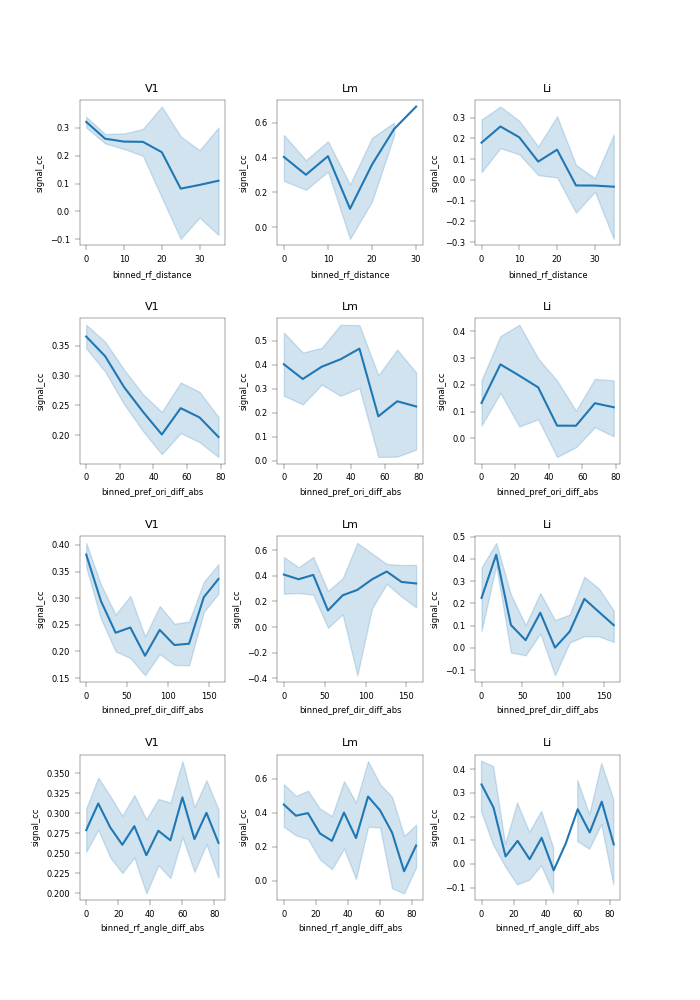

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [988]:
y_var = 'signal_cc'
x_var='rf_distance'
plot_params = ['rf_distance', 'pref_ori_diff_abs', 'pref_dir_diff_abs', 'rf_angle_diff_abs']

fig, axn = pl.subplots(len(plot_params),3, figsize=(7,10))
for ri, par in enumerate(plot_params):
    for va, vg in df.groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[ri, vi]
        ax.set_title(va)
        sns.lineplot(x='binned_%s' % par, y=y_var, ax=ax, data=vg)#,
#                     style='datakey')
        #ax.legend_.remove()
        ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5, top=0.9)

<IPython.core.display.Javascript object>


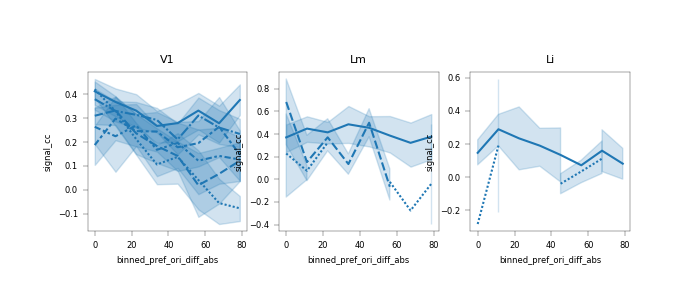

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [989]:
y_var = 'signal_cc'
x_var='pref_ori_diff_abs'
fig, axn = pl.subplots(1,3, figsize=(7,3))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    ax.set_title(va)
    sns.lineplot(x='binned_%s' % x_var, y=y_var, ax=ax, data=vg,
                style='datakey')
    ax.legend_.remove()
    ax.set_box_aspect(1)

In [990]:
ctx_step=25
max_dist=400

df = DF[DF.cortical_distance<=max_dist].copy()
ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

grp_step=100
grp_bins = np.arange(0, 1000+grp_step, grp_step)
df['distance_group'] = pd.cut(df['cortical_distance'], \
                                                grp_bins, include_lowest=True,
                                                labels=grp_bins[0:-1])
df['distance_group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in df['distance_group'].values]

<IPython.core.display.Javascript object>


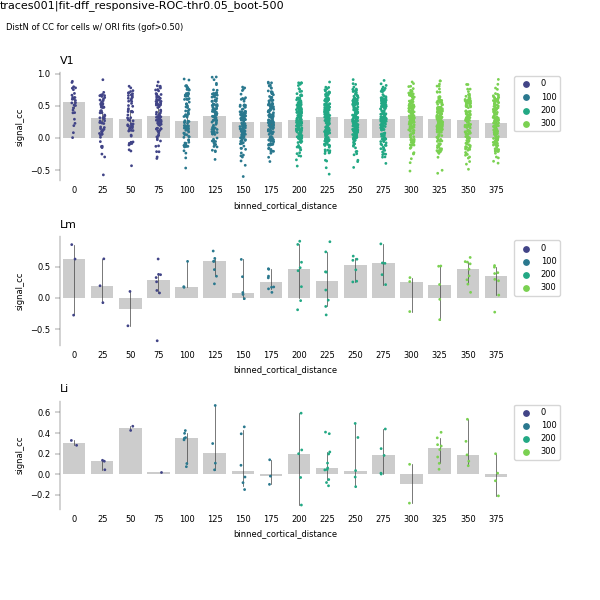

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta single-pair-distns_hue-distbin_gof0.50


In [991]:
# Ticks
min_npairs=0 #10
max_dist = 800
sorted_x_vars = [k for k, v in splitdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))

fig, axn = pl.subplots(3, 1, figsize=(6,6))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.barplot(x='binned_cortical_distance', y='signal_cc', ax=ax, data=vg,
                color=[0.8]*3, dodge=False,
               estimator=np.median, errwidth=0.5)
    sns.stripplot(x='binned_cortical_distance', y='signal_cc', ax=ax, data=vg,
               hue='distance_group_label', dodge=False, size=2, 
                  palette=grp_colors)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title(va, loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, hspace=0.5)
sns.despine(bottom=True)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'DistN of CC for cells w/ ORI fits (gof>%.2f)' % gof_thr)
figname = 'single-pair-distns_hue-distbin_gof%.2f' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [992]:
pg.anova(data=df,
         dv='signal_cc', between='distance_group_label')


Source  ddof1  ddof2         F     p-unc      np2
0  distance_group_label      3   2112  4.399359  0.004303  0.00621

In [993]:
pg.anova(data=df,
         dv='signal_cc', between='cortical_distance_label')


Source  ddof1  ddof2         F     p-unc       np2
0  cortical_distance_label     15   2100  3.368044  0.000012  0.023492

0.977287232875824 0.00039707805262878537
0.9938454031944275 0.044615697115659714


<IPython.core.display.Javascript object>


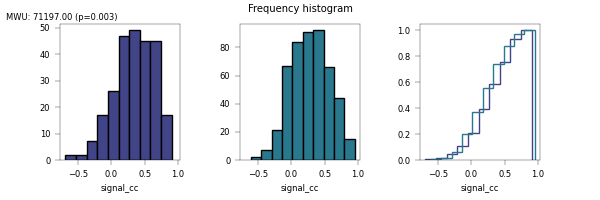

In [1013]:
y_var='signal_cc'
col1=grp_colors[0]
col2=grp_colors[100]
v1 = df[df.distance_group_label==0][y_var].values
v2 = df[df.distance_group_label==100][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)
w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2))
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k', color=col1)
ax2.hist(v2, bins=10, histtype='bar', ec='k', color=col2)
wts1 = np.ones_like(v1)/len(v1)
ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1)
wts2 = np.ones_like(v2)/len(v2)
ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
        weights=wts2)
for ax in fig.axes:
    ax.set_xlabel(y_var)
    
U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
fig.text(0.01, 0.9, 'MWU: %.2f (p=%.3f)' % (U, p))
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2)

<IPython.core.display.Javascript object>


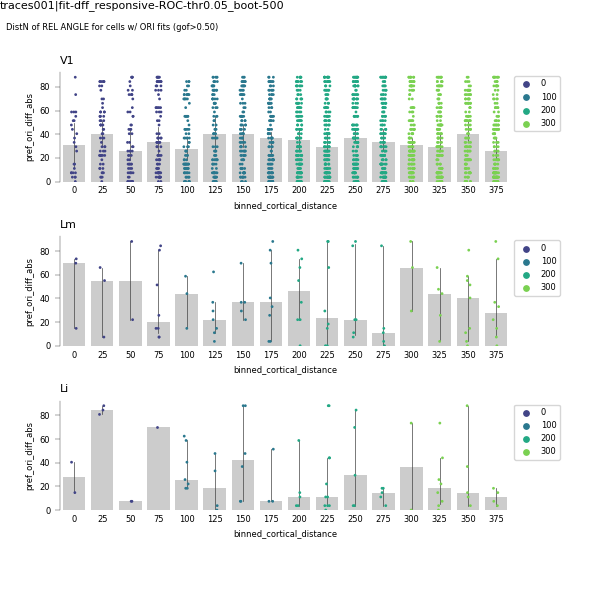

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta single-pair-distns_hue-distbin_THETA_gof0.50


In [1009]:
# Ticks
min_npairs=0 #10
max_dist = 800
sorted_x_vars = [k for k, v in splitdf.groupby(x_var) if k<max_dist]
# Colors
vals_ = dist_bins[dist_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
dist_colors = dict((k, v) for k, v in zip(vals_, cols_))

fig, axn = pl.subplots(3, 1, figsize=(6,6))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.barplot(x='binned_cortical_distance', y='pref_ori_diff_abs', ax=ax, data=vg,
                color=[0.8]*3, dodge=False,
               estimator=np.median, errwidth=0.5)
    sns.stripplot(x='binned_cortical_distance', y='pref_ori_diff_abs', ax=ax, data=vg,
               hue='distance_group_label', dodge=False, size=2, 
                  palette=grp_colors)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title(va, loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, hspace=0.5)
sns.despine(bottom=True)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'DistN of REL ANGLE for cells w/ ORI fits (gof>%.2f)' % gof_thr)
figname = 'single-pair-distns_hue-distbin_THETA_gof%.2f' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

0.9138503074645996 5.2083923979262536e-11
0.923651397228241 4.721759329964206e-15


<IPython.core.display.Javascript object>


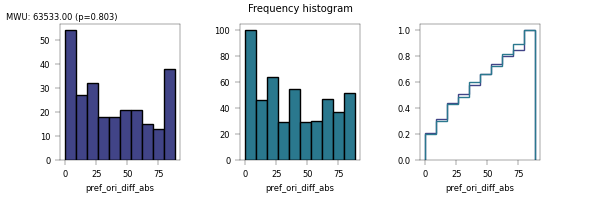

In [1014]:
y_var='pref_ori_diff_abs'
col1=grp_colors[0]
col2=grp_colors[100]
v1 = df[df.distance_group_label==0][y_var].values
v2 = df[df.distance_group_label==100][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)
w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2))
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k', color=col1)
ax2.hist(v2, bins=10, histtype='bar', ec='k', color=col2)
wts1 = np.ones_like(v1)/len(v1)
ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1)
wts2 = np.ones_like(v2)/len(v2)
ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
        weights=wts2)
for ax in fig.axes:
    ax.set_xlabel(y_var)
    
U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
fig.text(0.01, 0.9, 'MWU: %.2f (p=%.3f)' % (U, p))
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2)

In [373]:
import analyze2p.extraction.traces as traceutils

In [371]:
dk = '20190617_JC097_fov1'
df[(df.datakey==dk) & (df['cell_2']==399)]


neuron_pair  cell_1  cell_2  pref_dir_diff  pref_dir_diff_abs  \
2232     361_399     361     399       7.346939           7.346939   

      pref_ori_diff  pref_ori_diff_abs  rf_angle_diff  rf_angle_diff_abs  \
2232       7.346939           7.346939       0.517833           0.517833   

      response_pref  ...  binned_cortical_distance_label  distance_type  \
2232       0.049536  ...                             225            200   

      distance_label  signal_cc  noise_cc experiment  n_cells_y  \
2232           200.0   0.088267  0.098613   gratings         98   

      binned_pref_ori_diff_abs  binned_pref_dir_diff_abs binned_signal_cc  
2232                         0                         0                0  

[1 rows x 28 columns]

In [375]:
data_fpath = traceutils.get_data_fpath(dk,experiment_name='gratings')
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath,
                                                trace_type='corrected')
dff_traces, metrics = aggr.process_traces(raw_traces, labels, trace_type='dff',
                                           response_type='dff', trial_epoch='stimulus')


--- processed traces: dff


In [376]:
rid = 399
sdf[(sdf['sf']==0.1) & (sdf['size']==20) & (sdf['speed']==10) & (sdf['ori']==90)]

direction luminance  stimtype  xpos ypos aspect ori position speed  \
config017         0      None  gratings  25.0  0.0      1  90  (25, 0)    10   

            sf  size  
config017  0.1  20.0

In [378]:
cfg='config017'
#for labels[labels['cfg']==cfg].groupby('trial'):
    

In [387]:
rid2=203

In [388]:
meanr, stdr, ts = traceutils.get_mean_and_std_traces(rid, dff_traces, labels, [cfg], sdf)
meanr2, stdr2, ts2 = traceutils.get_mean_and_std_traces(rid2, dff_traces, labels, [cfg], sdf)


<IPython.core.display.Javascript object>


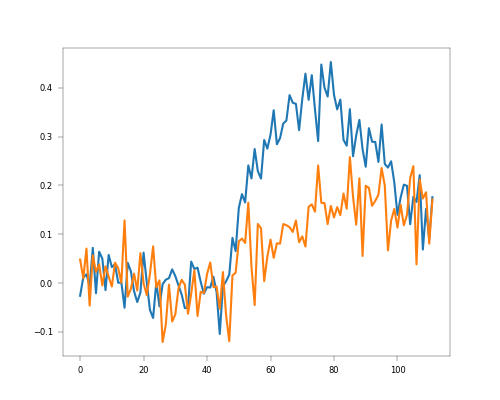

In [389]:
pl.figure()
pl.plot(meanr[0])
pl.plot(meanr2[0])

In [398]:
from scipy import signal
x=meanr[0]
#y = meanr2[0]
y =np.concatenate([x, x])
c = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode='full')
lags

array([-223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213,
       -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202,
       -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191,
       -190, -189, -188, -187, -186, -185, -184, -183, -182, -181, -180,
       -179, -178, -177, -176, -175, -174, -173, -172, -171, -170, -169,
       -168, -167, -166, -165, -164, -163, -162, -161, -160, -159, -158,
       -157, -156, -155, -154, -153, -152, -151, -150, -149, -148, -147,
       -146, -145, -144, -143, -142, -141, -140, -139, -138, -137, -136,
       -135, -134, -133, -132, -131, -130, -129, -128, -127, -126, -125,
       -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114,
       -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103,
       -102, -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,
        -91,  -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,
        -80,  -79,  -78,  -77,  -76,  -75,  -74,  -

In [400]:
s = spstats.pearsonr(x[lags], y[lags])
s

IndexError: index -223 is out of bounds for axis 0 with size 112

In [401]:
lags[np.argmax(c)]

-112

In [402]:
len(x), len(y)

(112, 224)

<IPython.core.display.Javascript object>


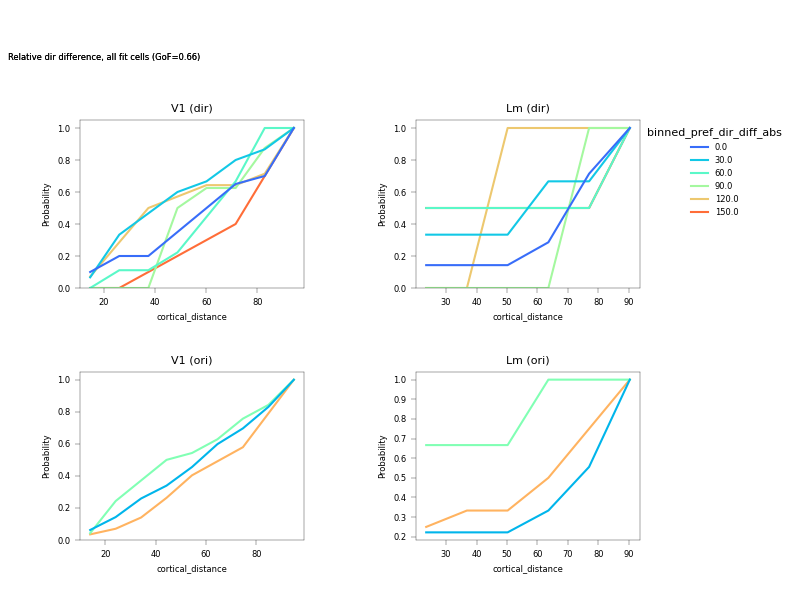

In [501]:

min_npairs=0 #10
x_var='cortical_distance'
cmap ='rainbow'

curr_areas = ['V1', 'Lm']
plotd = splitdf[(splitdf.cortical_distance<=100) & (splitdf.visual_area.isin(curr_areas))].copy()
fig, axn = pl.subplots(2,2, figsize=(8,6))
for va, vg in plotd.groupby('visual_area'):
    vi=visual_areas.index(va)
    for di, (stim_str, sg) in enumerate(vg.groupby('selectivity')):
        ax=axn[di, vi]
        ax.set_title("%s (%s)" % (va, stim_str))
        hue_label = 'pref_%s_diff_abs' % stim_str
        hue_bins = bin_lut[hue_label]
        df_ = cr.get_binned_X(sg, x_label=hue_label, x_bins=hue_bins, 
                         min_npairs=min_npairs, labels=hue_bins[0:-1])
        g = sns.histplot(x=x_var, hue='binned_%s' % hue_label, data=df_, ax=ax,
            cumulative=True, fill=None, element='poly', stat='probability',
            common_norm=False, palette=cmap, #hue_norm=(min_, max_), 
            line_kws={'lw': 2, 'alpha': 0.5})
        if vi==len(curr_areas)-1 and di==0:
            pplot.sns_histplot_legend(ax) #bbox_to_anchor=(1,1), loc='upper left', frameon=False)
        else:
            ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8, wspace=0.5, hspace=0.5)

In [106]:
splitdf[splitdf.cortical_distance<=100].groupby(['selectivity', 'visual_area']).count()

neuron_pair  cell_1  cell_2  pref_dir_diff  \
selectivity visual_area                                               
asi         Lm                     6       6       6              6   
            V1                    46      46      46             46   
dsi         Lm                     2       2       2              2   
            V1                     9       9       9              9   

                         pref_dir_diff_abs  pref_ori_diff  pref_ori_diff_abs  \
selectivity visual_area                                                        
asi         Lm                           6              6                  6   
            V1                          46             46                 46   
dsi         Lm                           2              2                  2   
            V1                           9              9                  9   

                         rf_angle_diff  rf_angle_diff_abs  response_pref  \
selectivity visual_area                                                    
asi         Lm                       6                  6              6   
            V1                      46                 46             46   
dsi         Lm                       2                  2              2   
            V1                       9                  9              9   

                         rf_distance  max_ecc  min_ecc  cortical_distance  \
selectivity visual_area                                                     
asi         Lm                     6        6        6                  6   
            V1                    46       46       46                 46   
dsi         Lm                     2        2        2                  2   
            V1                     9        9        9                  9   

                         datakey  n_cells  
selectivity visual_area                    
asi         Lm                 6        6  
            V1                46       46  
dsi         Lm                 2        2  
            V1                 9        9

<IPython.core.display.Javascript object>


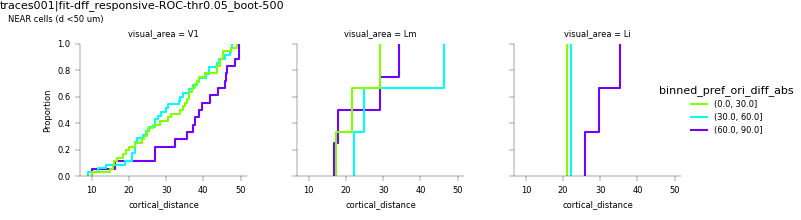

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs__cortical_distance_NEAR


<IPython.core.display.Javascript object>


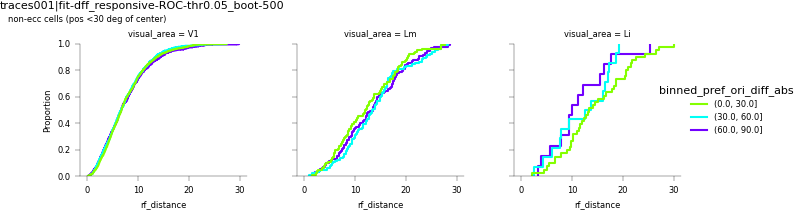

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs__rf_distance_NEAR


In [960]:
hue_label = 'pref_ori_diff_abs'
# hue_label = 'rf_angle_diff_abs'
cmap='hsv'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                bin_lut[hue_label], retbins=True)
plotd0 = currdf[currdf['max_ecc']<=np.inf]

upper_lim=50
plotd = plotd0[plotd0['cortical_distance']<=upper_lim].copy()
%matplotlib notebook
# ------------------------------------------------
x_var='cortical_distance'
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=x_var, height=2.2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
fg.fig.text(0.01, 0.9, 'NEAR cells (d <%i um)' % upper_lim)

pplot.label_figure(fg.fig, data_id)
figname = '%s__%s_NEAR' % (hue_label, x_var)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
# ------------------------------------------------
upper_lim=30
x_var='rf_distance'
plotd = plotd0[plotd0['rf_distance']<upper_lim].copy()
fg = sns.displot(data=plotd, col='visual_area', col_order=visual_areas,
           x=x_var, height=2.2,
           hue='binned_%s' % hue_label, palette=cmap, kind='ecdf')
fg.fig.text(0.01, 0.9, 'non-ecc cells (pos <%i deg of center)' % upper_lim)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
pplot.label_figure(fg.fig, data_id)
figname = '%s__%s_NEAR' % (hue_label, x_var)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


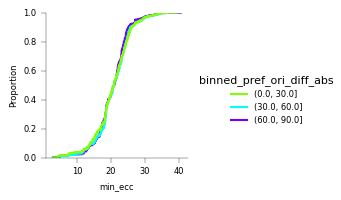

<IPython.core.display.Javascript object>


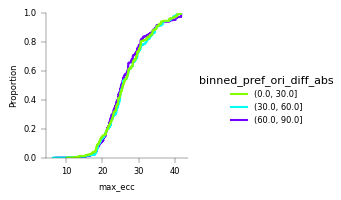

In [961]:
for ai, x_var in enumerate(['min_ecc', 'max_ecc']):

    sns.displot(data=plotd, x=x_var, height=2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')

<IPython.core.display.Javascript object>


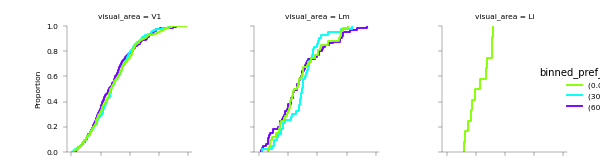

In [457]:
# hue_label = 'pref_ori_diff_abs'
# cmap='hsv'
# currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
#                                                 bin_lut[hue_label], retbins=True)
# plotd0 = currdf[currdf['max_ecc']<=np.inf]
# plotd = plotd0[plotd0['cortical_distance']<=1000].copy()

dist_var = 'cortical_distance'
lower_lim=None
upper_lim=1000
hue_label = 'pref_ori_diff_abs'
hue_bins=bin_lut[hue_label]

df_ = cr.get_bins_within_limits(currdf, bin_name=dist_var, 
                    upper_lim=upper_lim, lower_lim=lower_lim)
df_pass = cr.get_binned_X(df_, x_label=hue_label, x_bins=hue_bins, 
                     min_npairs=min_npairs)

%matplotlib notebook
x_var='cortical_distance'
fg = sns.displot(data=df_pass, col='visual_area', col_order=visual_areas,
           x=dist_var, height=2,
           hue='binned_%s' % hue_label, palette=cmap,
           kind='ecdf')
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5, bottom=0.15, 
                   hspace=0.7, top=0.85)

# pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.3, top=0.8)
# pplot.label_figure(fg.fig, data_id)
# figname = '%s__%s' % (hue_label, x_var)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [963]:
currdf.groupby(['visual_area', 'binned_%s' % hue_label])['neuron_pair'].count()

visual_area  binned_pref_ori_diff_abs
Li           (0.0, 30.0]                   46
             (30.0, 60.0]                  16
             (60.0, 90.0]                  14
Lm           (0.0, 30.0]                  104
             (30.0, 60.0]                 109
             (60.0, 90.0]                 100
V1           (0.0, 30.0]                 1353
             (30.0, 60.0]                 843
             (60.0, 90.0]                 854
Name: neuron_pair, dtype: int64

<IPython.core.display.Javascript object>


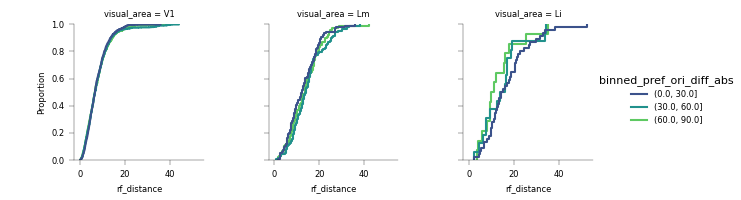

In [964]:
x_var='rf_distance'
hue_label = 'pref_ori_diff_abs'
cmap='viridis'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                bin_lut[hue_label], retbins=True)

%matplotlib notebook
sns.displot(data=currdf, x=x_var, hue='binned_%s' % hue_label,
            palette=cmap, kind='ecdf', height=2,
           col='visual_area', col_order=visual_areas, )
# fig, axn = pl.subplots(1,3, figsize=(7,3))
# for va, vg in currdf.groupby('visual_area'):
#     ax=axn[visual_areas.index(va)]
#     ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
#              ax=ax, bins=20, kde=False, fill=False, element='poly', 
#              palette=cmap, cumulative=False, lw=2)
#     ax.set_title(va)
#     if va!='Li':
#         ax.legend_.remove()
#     else:
#         pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

In [825]:
np.arange(0, 45, 5) 

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40])

<IPython.core.display.Javascript object>


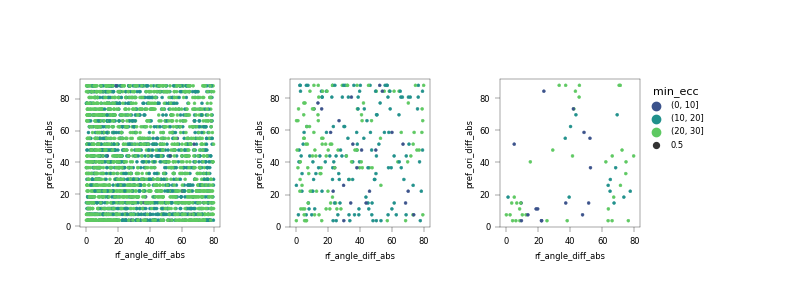

In [826]:

x_var = 'rf_angle_diff_abs'
y_var = 'pref_ori_diff_abs'
hue_label = 'min_ecc'
#test_bins = np.arange(0, 50, 10) 
test_bins = np.arange(0, 40, 10) 

currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                test_bins, retbins=True)

fig, axn = pl.subplots(1,3, figsize=(8,3))
for va, vg in currdf.dropna().groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.scatterplot(x=x_var, y=y_var, data=vg, ax=ax, 
                hue='binned_%s' % hue_label, palette='viridis',
                size=0.5, edgecolor=None, marker='.')
    ax.legend_.remove()
    ax.set_aspect('equal')
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
              title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, wspace=0.5)

<IPython.core.display.Javascript object>


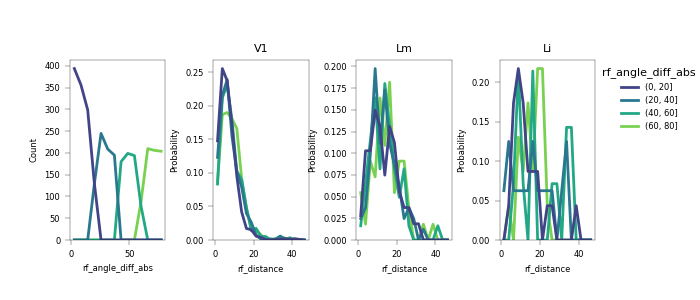

In [829]:
#x_var='pref_ori_diff_abs'
x_var='rf_distance'

hue_label = 'rf_angle_diff_abs'
cmap='viridis'
test_bins = np.arange(0, 90, 20)
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                test_bins, retbins=True)

%matplotlib notebook
fig, axn = pl.subplots(1,4, figsize=(7,3))
ax=axn[0]
ax = sns.histplot(x=hue_label, data=currdf, hue='binned_%s' % hue_label,
             ax=ax, kde=False, fill=False, element='poly', 
             palette=cmap, cumulative=False, lw=2)
ax.legend_.remove()
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)+1]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=bin_lut[x_var], kde=False, fill=False, element='poly', 
             palette=cmap, cumulative=False, lw=2, 
                      stat='probability', common_norm=False)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.85, wspace=0.5, bottom=0.2, top=0.8)

In [759]:
np.arange(0, 90, 20)

array([ 0, 20, 40, 60, 80])

In [675]:
currdf['binned_%s' % hue_label].dropna().unique()

[(0.0, 15.0], (75.0, 90.0], (30.0, 45.0], (15.0, 30.0], (45.0, 60.0], (60.0, 75.0]]
Categories (6, interval[float64]): [(0.0, 15.0] < (15.0, 30.0] < (30.0, 45.0] < (45.0, 60.0] < (60.0, 75.0] < (75.0, 90.0]]

<IPython.core.display.Javascript object>


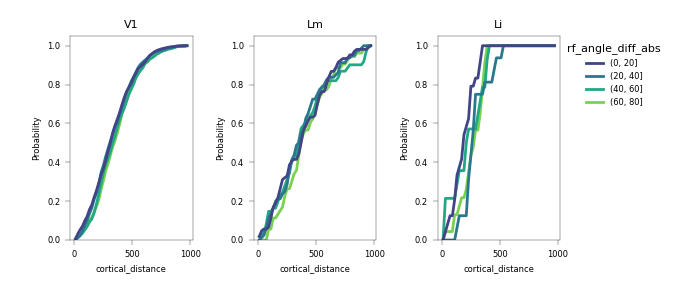

In [761]:
hue_label = 'rf_angle_diff_abs'
rf_ang_bins=np.arange(0, 90, 20)
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                            rf_ang_bins, retbins=True)
x_var='cortical_distance'

%matplotlib notebook
fig, axn = pl.subplots(1,3, figsize=(7,3))
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=ctx_dist_bins, kde=False, fill=False, element='poly', 
             palette='viridis', cumulative=True, lw=2,
                     stat='probability', common_norm=False)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

<IPython.core.display.Javascript object>


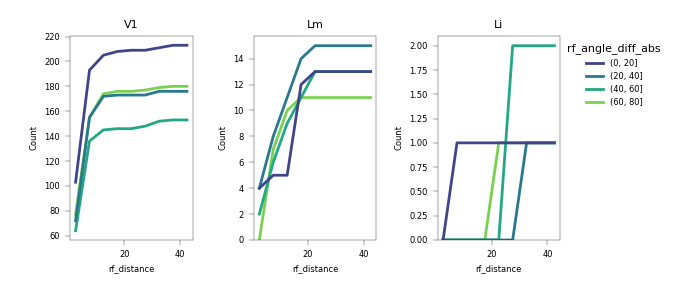

In [512]:
x_var='rf_distance'
hue_label = 'rf_angle_diff_abs'
currdf['binned_%s' % hue_label], bin_edges = pd.cut(currdf[hue_label], \
                                                rf_ang_bins, retbins=True)
%matplotlib notebook
fig, axn = pl.subplots(1,3, figsize=(7,3))
for va, vg in currdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    ax = sns.histplot(x=x_var, data=vg, hue='binned_%s' % hue_label,
             ax=ax, bins=rf_dist_bins, kde=False, fill=False, element='poly', 
             palette='viridis', cumulative=True, lw=2)
    ax.set_title(va)
    if va!='Li':
        ax.legend_.remove()
    else:
        pplot.sns_histplot_legend(ax, title=hue_label)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)

In [489]:
d_list=[]
big_theta_diffs = currdf[currdf['pref_ori_diff_abs']>70].copy()
for (va, dk), vg in big_theta_diffs.groupby(['visual_area', 'datakey']):
    rois_ = np.union1d(vg['cell_1'].unique(), vg['cell_2'].unique())
    d_ = df[(df.visual_area==va) & (df.datakey==dk) & (df['cell'].isin(rois_))].copy()
    d_list.append(d_)
df_ = pd.concat(d_list)    

In [490]:
# big_theta_diffs[(big_theta_diffs.visual_area=='V1')]\
# .sort_values(by='binned_cortical_distance')
va='V1'
# dk='20191006_JC110_fov1'
# rois_=[102, 103]
dk = '20190617_JC097_fov1'

big_theta_diffs[(big_theta_diffs.visual_area=='V1')
               & (big_theta_diffs.datakey==dk)]\
.sort_values(by='binned_cortical_distance')

neuron_pair  cell_1  cell_2  pref_dir_diff  pref_dir_diff_abs  \
2170       60_65      60      65     -73.469388          73.469388   
2073      21_224      21     224     -73.469388          73.469388   
2061       21_40      21      40      95.510204          95.510204   
2074      21_230      21     230     -95.510204          95.510204   
2166      50_420      50     420     -95.510204          95.510204   
2152       50_92      50      92     -95.510204          95.510204   
2221      92_424      92     424     -88.163265          88.163265   
2209      92_162      92     162      95.510204          95.510204   
2188      60_432      60     432     -80.816327          80.816327   
2243     142_203     142     203      95.510204          95.510204   
2125      40_420      40     420    -102.857143         102.857143   
2265     162_420     162     420     -95.510204          95.510204   
2172      60_107      60     107     -95.510204          95.510204   
2354     420_424     420     424     -88.163265          88.163265   
2111       40_92      40      92    -102.857143         102.857143   
2208      92_142      92     142      88.163265          88.163265   
2251     142_420     142     420     -88.163265          88.163265   
2295     203_230     203     230      88.163265          88.163265   
2063       21_50      21      50      88.163265          88.163265   
2257     162_203     162     203      88.163265          88.163265   
2117      40_203      40     203      80.816327          80.816327   
2158      50_203      50     203      88.163265          88.163265   
2320     230_420     230     420      88.163265          88.163265   
2302     203_424     203     424      88.163265          88.163265   
2298     203_361     203     361     -88.163265          88.163265   
2098      25_249      25     249     102.857143         102.857143   
2300     203_399     203     399     -80.816327          80.816327   
2214      92_230      92     230     -88.163265          88.163265   
2175      60_182      60     182     -88.163265          88.163265   
2176      60_183      60     183     -73.469388          73.469388   
2093      25_182      25     182      95.510204          95.510204   
2090      25_107      25     107      88.163265          88.163265   
2106      25_432      25     432     102.857143         102.857143   
2180      60_249      60     249     -80.816327          80.816327   
2079      21_399      21     399      95.510204          95.510204   
2229     107_224     107     224      73.469388          73.469388   
2068      21_142      21     142      80.816327          80.816327   
2069      21_162      21     162      88.163265          88.163265   
2181      60_314      60     314    -102.857143         102.857143   
2350     399_420     399     420    -102.857143         102.857143   
2081      21_424      21     424     -95.510204          95.510204   
2341     361_420     361     420     -95.510204          95.510204   
2299     203_368     203     368      73.469388          73.469388   
2307     224_314     224     314     -80.816327          80.816327   
2217      92_361      92     361      95.510204          95.510204   
2077      21_361      21     361      88.163265          88.163265   
2219      92_399      92     399     102.857143         102.857143   
2099      25_314      25     314      80.816327          80.816327   
2346     368_420     368     420     102.857143         102.857143   
2218      92_368      92     368    -102.857143         102.857143   

      pref_ori_diff  pref_ori_diff_abs  rf_angle_diff  rf_angle_diff_abs  \
2170     -73.469388          73.469388     -49.075309          49.075309   
2073     -73.469388          73.469388      33.308342          33.308342   
2061     -84.489796          84.489796      48.870764          48.870764   
2074      84.489796          84.489796     -40.726048          40.726048   
2166      84.489796          84.489796     -27.808300 

In [491]:
va='V1'
# dk='20191006_JC110_fov1'
# rois_=[102, 103]
dk = '20190617_JC097_fov1'
df_[(df_.visual_area==va) & (df_.datakey==dk)]\
[['cell', 'theta_pref', 'response_pref', 'asi', 'dsi', 'gof', 'sf', 'size', 'speed']]
# rois_ = [69, 73]
# df_[(df_.visual_area==va) & (df_.datakey==dk) & (df_.cell.isin(rois_))]\
# [['cell', 'theta_pref', 'response_pref', 'asi', 'dsi']]

cell  theta_pref  response_pref       asi       dsi       gof   sf  \
218    21    0.000000       0.071097  0.419196  0.560769  0.515804  0.5   
219    25  124.897959       0.097348  0.544721  0.226399  0.515422  0.5   
220    40   95.510204       0.159585  0.494238  0.156271  0.536622  0.1   
222    50   88.163265       0.109166  0.384916  0.499996  0.638187  0.5   
223    60  308.571429       0.138274  0.200429  0.484791  0.512174  0.5   
224    65  235.102041       0.134620  0.142898  0.421928  0.530916  0.5   
225    92  352.653061       0.112101  0.622714  0.281595  0.544758  0.1   
226   107  213.061224       0.114031  0.210019  0.573874  0.566227  0.5   
227   142   80.816327       0.083951  0.685170  0.141031  0.605964  0.1   
228   162   88.163265       0.098181  0.705657  0.432000  0.572517  0.5   
229   182  220.408163       0.087572  0.675880  0.136135  0.707860  0.1   
230   183  235.102041       0.136187  0.480868  0.258779  0.619159  0.1   
231   203  176.326531       0.212901  0.497368  0.373554  0.716905  0.5   
232   224  286.530612       0.184490  0.522240  0.107676  0.618129  0.1   
233   230  264.489796       0.085288  0.520391  0.276123  0.572246  0.5   
234   249  227.755102       0.092308  0.506470  0.445057  0.602027  0.1   
235   314  205.714286       0.154637  0.413782  0.501833  0.608500  0.1   
236   361   88.163265       0.167320  0.525220  0.290632  0.782824  0.5   
237   368  249.795918       0.120902  0.544040  0.087039  0.714254  0.1   
238   399   95.510204       0.216855  0.654544  0.041390  0.892970  0.1   
239   420  352.653061       0.085583  0.397403  0.732893  0.713843  0.5   
240   424  264.489796       0.094388  0.503657  0.691823  0.610860  0.1   
242   432  227.755102       0.109365  0.420308  0.371860  0.510393  0.5   

      size  speed  
218  200.0   10.0  
219   20.0   20.0  
220   20.0   20.0  
222  200.0   10.0  
223   20.0   20.0  
224  200.0   20.0  
225   20.0   20.0  
226  200.0   20.0  
227  200.0   10.0  
228  200.0   10.0  
229  200.0   10.0  
230  200.0   20.0  
231   20.0   10.0  
232  200.0   10.0  
233   20.0   10.0  
234  200.0   20.0  
235  200.0   20.0  
236   20.0   10.0  
237   20.0   10.0  
238   20.0   20.0  
239   20.0   20.0  
240  200.0   20.0  
242  200.0   20.0

<IPython.core.display.Javascript object>


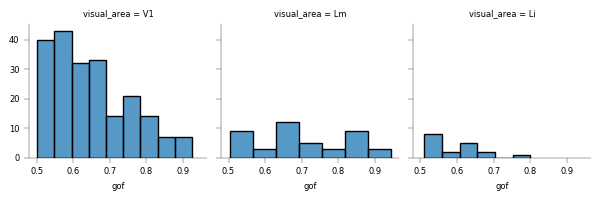

In [417]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'gof')

<IPython.core.display.Javascript object>


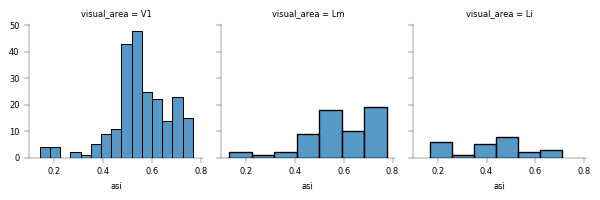

In [321]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'asi')

<IPython.core.display.Javascript object>


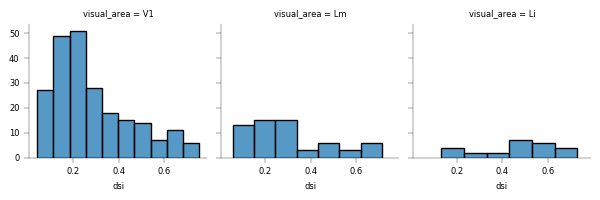

In [322]:
fg = sns.FacetGrid(data=df_, col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.histplot, 'dsi')

In [298]:
print(angdists.groupby(['visual_area'])['cortical_distance'].max())

angdists0 = angdists[angdists['cortical_distance']<=500].copy()

visual_area
Li     535.671223
Lm    1066.254662
V1    1160.609688
Name: cortical_distance, dtype: float64


In [309]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
# Bin data
to_quartile='rf_distance'
n_bins=20
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(angdists0, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]

# Count N pairs in each bin
pairs_per_bin = bcorrs.groupby(['visual_area', 'binned_%s' % to_quartile])\
                ['neuron_pair'].count().reset_index()\
                .rename(columns={'neuron_pair': 'n_pairs'})
pairs_per_bin['bin_value'] = [bin_lut[b] for b \
                               in pairs_per_bin['binned_%s' % to_quartile]]
# bin_column='bin_value'

<IPython.core.display.Javascript object>


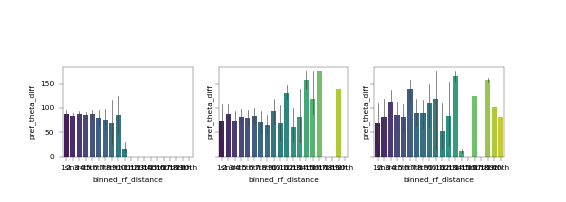

In [310]:
y_var='pref_theta_diff'
x_var = 'binned_%s' % to_quartile

n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 5
n_iter=100

xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    sns.barplot(x=x_var, y=y_var, data=cc0, ax=ax, palette='viridis',
               estimator=np.mean, errwidth=0.5)

pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)


<IPython.core.display.Javascript object>


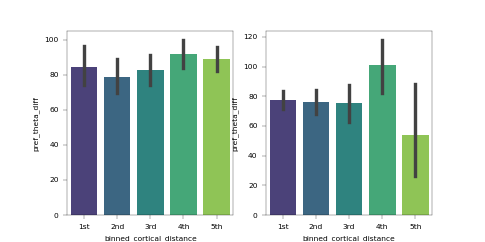

In [311]:
near_ = angdists[angdists['cortical_distance']<=250].copy()
far_ = angdists[angdists['cortical_distance']>=500].copy()
y_var = 'pref_theta_diff'

# Bin data
to_quartile='cortical_distance'
n_bins=5
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=near_, ax=ax,
           palette='viridis')
ax=axn[1]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=far_, ax=ax,
           palette='viridis')
pl.subplots_adjust(bottom=0.2, right=0.8)

In [312]:
angdists['pref_theta_diff']

0         7.346939
1        88.163265
2         7.346939
3       139.591837
4         0.000000
           ...    
2770    146.938776
2771    168.979592
2772    154.285714
2773    161.632653
2774     44.081633
Name: pref_theta_diff, Length: 2775, dtype: float64

In [314]:
x_var='rf_distance'
print(angdists.groupby(['visual_area'])[x_var].max())


curr_df = angdists[angdists[x_var]<=50].copy()

visual_area
Li    53.261005
Lm    49.531952
V1    31.980850
Name: rf_distance, dtype: float64


In [315]:
near_lim = 20
far_lim = 30
near_ = curr_df[curr_df[x_var]<near_lim].copy()
far_ = curr_df[curr_df[x_var]>far_lim].copy()

# Bin data
to_quartile='pref_theta_diff'
n_bins=5
use_quartile=False
# ---------------------------------
# bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
#                                             cmap=cmap)
bins=[0, 45, 90, 135, 180]
bin_labels=bins[0:-1]

near_['binned_%s' % to_quartile], bin_edges = pd.cut(near_[to_quartile], \
                                                bins, labels=None, retbins=True)
near_['distance_label'] = 'd<%i um' % near_lim
near_['distance'] = 'near'

far_['binned_%s' % to_quartile], bin_edges = pd.cut(far_[to_quartile], \
                                                bins, labels=None, retbins=True)
far_['distance_label'] = 'd>%i um' % far_lim
far_['distance'] = 'far'


dists = pd.concat([near_, far_], axis=0, ignore_index=True)

# near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)
# far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


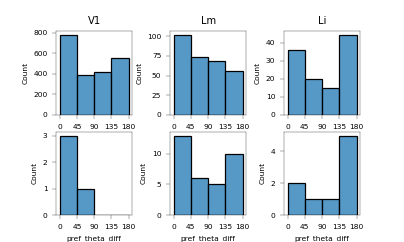

In [316]:
fig, axn = pl.subplots(2, 3, figsize=(5,3))
for va, vg in dists.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax=axn[0, ai]
    ax.set_title(va)
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='near'], 
                 ax=ax, bins=bins)
    ax=axn[1, ai]
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='far'], ax=ax, bins=bins)

for ax in axn.flat:
    ax.set_xticks(bins)
pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)

In [162]:
cnts_near = near_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_near['distance'] = 'near'
cnts_far = far_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_far['distance'] = 'far'

cnts = pd.concat([cnts_far, cnts_near], axis=0)
cnts

visual_area binned_pref_theta_diff  neuron_pair distance
0           Li                (0, 45]           97      far
1           Li               (45, 90]           40      far
2           Li              (90, 135]            0      far
3           Li             (135, 180]            0      far
4           Lm                (0, 45]          150      far
5           Lm               (45, 90]          127      far
6           Lm              (90, 135]            0      far
7           Lm             (135, 180]            0      far
8           V1                (0, 45]          990      far
9           V1               (45, 90]          641      far
10          V1              (90, 135]            0      far
11          V1             (135, 180]            0      far
0           Li                (0, 45]            4     near
1           Li               (45, 90]            3     near
2           Li              (90, 135]            0     near
3           Li             (135, 180]            0     near
4           Lm                (0, 45]            4     near
5           Lm               (45, 90]            7     near
6           Lm              (90, 135]            0     near
7           Lm             (135, 180]            0     near
8           V1                (0, 45]           35     near
9           V1               (45, 90]           26     near
10          V1              (90, 135]            0     near
11          V1             (135, 180]            0     near

<IPython.core.display.Javascript object>


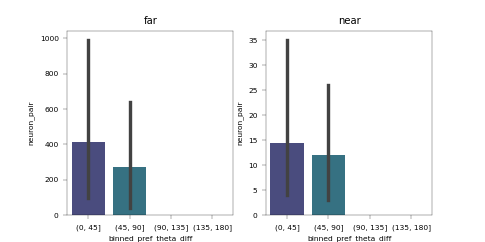

In [163]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
for ax, (cd, cg) in zip(axn.flat, cnts.groupby('distance')):
    sns.barplot(x='binned_%s' % to_quartile, y='neuron_pair', data=cg, ax=ax,
           palette='viridis')
    ax.set_title(cd)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [ ]:
va='V1' 
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

### Signal corrs

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

{0: 'r', 315: 'r', 180: 'b', 225: 'b'}


<IPython.core.display.Javascript object>


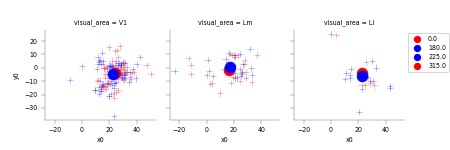

V1: nasal=(24.2, -4.1) | temporal (22.3, -4.9)
Lm: nasal=(16.7, -1.8) | temporal (17.2, 0.8)
Li: nasal=(22.8, -3.6) | temporal (22.6, -6.4)


In [311]:
# 0: Nasal, 180: Temporal
# 90: Upward, 270: Downward
nasal_color = 'r'
temporal_color='b'
nasal_ = [0, 315]
temporal_ = [180, 225]

theta_colors = dict((k, nasal_color) for k in nasal_)
theta_colors.update(dict((k, temporal_color) for k in temporal_))
print(theta_colors)

curr_oris = theta_colors.keys() #[0, 180]

currdata = DF[(DF['dsi']>=0.1) & (DF['tested_theta'].isin(curr_oris))].copy()

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2,
                   data=currdata)
fg.map(sns.scatterplot, 'x0', 'y0', 'tested_theta', #palette=theta_colors,
      alpha=0.5, palette=theta_colors, marker='+', facecolor='none')
# sns.scatterplot(x='x0', y='y0', hue='tested_theta', data=df_, ax=ax,
#                palette=theta_colors)
pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

for ai, va in enumerate(visual_areas):
    ax = fg.axes.flat[ai]
    df_ = currdata[currdata.visual_area==va].copy()
    cx_n, cy_n = hutils.CoM(df_[df_['tested_theta'].isin(nasal_)][['x0', 'y0']])
    cx_t, cy_t = hutils.CoM(df_[df_['tested_theta'].isin(temporal_)][['x0', 'y0']])
    
    ax.plot(cx_n, cy_n, color=nasal_color, marker='o', markersize=10)
    ax.plot(cx_t, cy_t, color=temporal_color, marker='o', markersize=10)

    print('%s: nasal=(%.1f, %.1f) | temporal (%.1f, %.1f)' % (va, cx_n, cy_n, cx_t, cy_t))
    

In [282]:
%matplotlib notebook

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

cell_1  cell_2  signal_cc neuron_pair  noise_cc visual_area  \
0         172     187  -0.478374     172_187  0.044495          Li   
1         172     216   0.727695     172_216  0.246881          Li   
2         172     220   0.783481     172_220 -0.004236          Li   
3         172     235   0.099065     172_235 -0.005421          Li   
4         172     253   0.135893     172_253  0.067974          Li   
...       ...     ...        ...         ...       ...         ...   
18042     237     266   0.460840     237_266  0.240423          V1   
18043     237     313   0.504684     237_313  0.081655          V1   
18044     245     266   0.708482     245_266  0.408278          V1   
18045     245     313   0.457018     245_313  0.116141          V1   
18046     266     313   0.601928     266_313  0.082570          V1   

                   datakey  cortical_distance binned_dist  pref_theta_diff  
0      20190314_JC070_fov1         217.661674     100-300        95.510204  
1      20190314_JC070_fov1         451.735098     300-500        -7.346939  
2      20190314_JC070_fov1         456.918526     300-500        -7.346939  
3      20190314_JC070_fov1         662.784857        >500       124.897959  
4      20190314_JC070_fov1         468.471708     300-500       -58.775510  
...                    ...                ...         ...              ...  
18042  20191006_JC110_fov1         172.559270     100-300      -161.632653  
18043  20191006_JC110_fov1         359.807776     300-500        51.428571  
18044  20191006_JC110_fov1          96.025434        <100      -168.979592  
18045  20191006_JC110_fov1         443.795066     300-500        44.081633  
18046  20191006_JC110_fov1         532.308071        >500      -146.938776  

[18047 rows x 10 columns]

In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


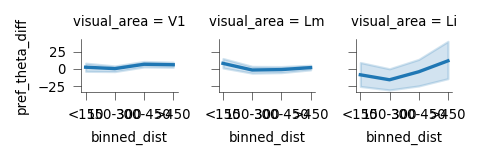

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

visual_area              datakey binned_dist binned_theta  cell_1  cell_2  \
40          Li  20190314_JC070_fov1        <150       -180.0   297.0   318.0   
41          Li  20190314_JC070_fov1        <150       -140.0   279.0   297.0   
43          Li  20190314_JC070_fov1        <150        -60.0   218.0   253.0   
44          Li  20190314_JC070_fov1        <150        -20.0   254.0   270.5   
51          Li  20190314_JC070_fov1     150-300       -140.0   211.0   259.5   

    signal_cc  noise_cc  cortical_distance  pref_theta_diff    abs_diff  
40   0.050655  0.433490         107.332928      -176.326531  176.326531  
41  -0.149087 -0.083493         107.157176      -154.285714  154.285714  
43   0.293214  0.181292         101.372948       -51.428571   51.428571  
44   0.541135  0.144238          93.358755       -18.367347   18.367347  
51  -0.128815  0.023185         271.443274      -154.285714  154.285714

In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


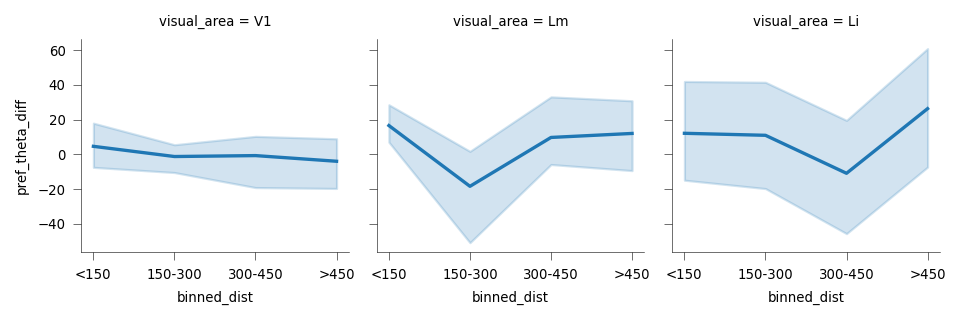

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


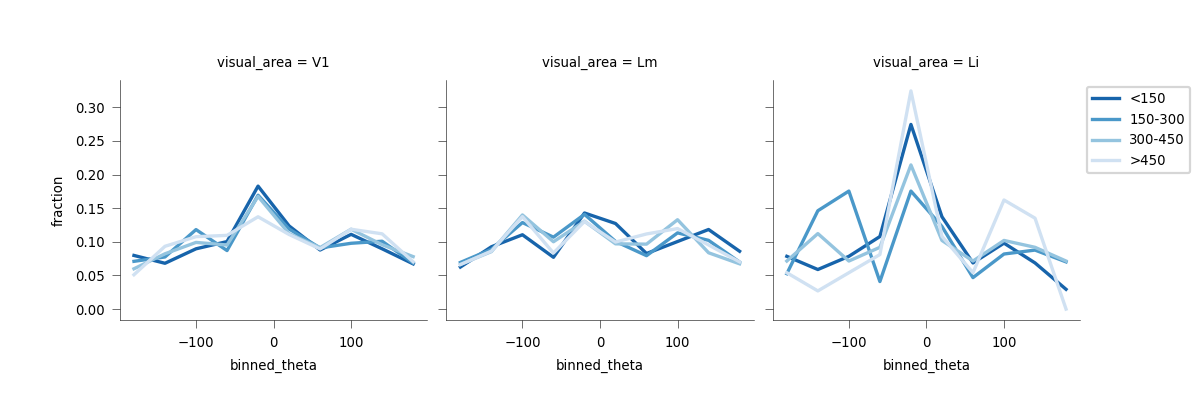

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


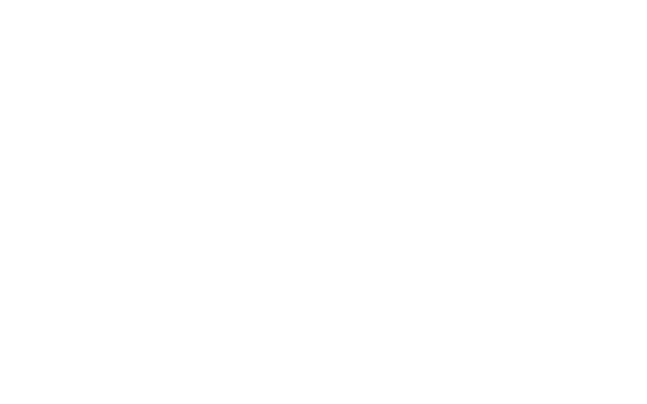

Text(0.0, 0.95, 'Common to RFs/gratings (GoF=0.50)')

In [31]:
gof_thr=0.5
# if pass_gof:
#     plotd = finaldf[finaldf['gof']>gof_thr].copy().dropna()
# else:
plotd = finaldf.copy()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5
bar_width=15.
bin_size = 10
# -----------------------------------------
max_ori = 360.
ori_names = np.arange(0, max_ori+45, 45)
ori_bins = np.arange(0, max_ori+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
rf_bins = np.arange(-90, 90+bin_size, bin_size)
# plot.
fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

# figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [ ]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', 
                   boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [ ]:
rf_color='k'
ori_color='cornflowerblue'

plotd = finaldf.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'rf_theta_deg' #'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, 
                                 boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, 
                    color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))

        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
# figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# print(curr_dst_dir, figname)